In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from scipy.stats import describe
from scipy.stats import mannwhitneyu
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import seaborn as sns

In [3]:
#uncomment to get package versions used in notebook
#pip list

### Info on Data sources

#### ercc spike-ins

The ERCC spike-in control is a mixture of 92 synthetic polyadenylated oligonucleotides of 250-2000 nucleotides long that are meant to resemble human transcripts.

#### 1. human cell dataset with ercc spike-ins

SEQC benchmark data set and data from ENCODE project

The Sequencing Quality Control Consortium generated two datasets from two reference RNA samples in order to evaluate transcriptome profiling by next-generation sequencing technology. Each sample contains one of the reference RNA source and a set of synthetic RNAs from the External RNA Control Consortium (ERCC) at known concentrations.

Group A contains 5 replicates of the Strategene Universal Human Reference RNA (UHRR), which is composed of total RNA from 10 human cell lines, with 2% by volume of ERCC mix 1.

Group B includes 5 replicate samples of the Ambion Human Brain Reference RNA (HBRR) with 2% by volume of ERCC mix 2.

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49712

Rapaport F, Khanin R, Liang Y, Pirun M et al. Comprehensive evaluation of differential gene expression analysis methods for RNA-seq data. Genome Biol 2013;14(9):R95

#### 2. Arabidopsis dataset with ercc spike-ins

Arabidopsis embryos possess unique transcriptomes relative to other plant tissues including somatic embryos, and can be partitioned into four transcriptional phases with characteristic biological processes.

By comprehensively comparing embryonic and post-embryonic transcriptomes, we found that embryonic transcriptomes do not resemble any other plant tissue we analyzed. Moreover, transcriptome clustering analyses revealed the presence of four distinct phases of embryogenesis which are enriched in specific biological processes.

Two ERCC controls were used for the experiment: ERCC Mix 1 was used for flight samples and ERCC 2 was used for ground control samples. Briefly, 1 μl of 1:2000 diluted RNA spike-in ERCC (half the amount suggested in the ERCC user guide) spike to 50 ng of total RNA 

Falko Hofmann· Michael A. Schon· Michael D. Nodine. 2019: The embryonic transcriptome of Arabidopsis thaliana Plant Reproduction (2019) 32:77–91 https://doi.org/10.1007/s00497-018-00357-2

GSM4880354	WS Root, Flight, Blue Origin, replicate 1, ercc mix1

GSM4880355	WS Root, Flight, Blue Origin, replicate 2, ercc mix1

GSM4880356	WS Root, Flight, Blue Origin, replicate 3, ercc mix1

GSM4880357	WS Root, Ground Control, Blue Origin, replicate 1, ercc mix2

GSM4880358	WS Root, Ground Control, Blue Origin, replicate 2, ercc mix2

GSM4880359	WS Root, Ground Control, Blue Origin, replicate 3, ercc mix2

#### 3. Danio rerio dataset
Datasets:
https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA325275&o=acc_s%3Aa

Article:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5264326/

Reference genome and gff:
https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_other/Danio_rerio/latest_assembly_versions/GCF_000002035.6_GRCz11/

zebrafish grouped into either SBS surgery (n = 29, ercc mix2) or sham surgery (n = 28, ercc mix1) groups. 3 fish from each group were harvested for RNA sequencing at 2 weeks and the remaining fish were harvested for evaluation by histology or RT-qPCR. 

### Read and prepare dataframes

In [4]:
# paths to files
ercc_p = './ercc_spikedata.tsv'
# 1. human + ercc
hs_starsal_p = './deseq_hsdata/ssal_hs_DE.tsv'
hs_starrsem_p = './deseq_hsdata/srsem_hs_DE.tsv'
hs_starfc_p = './deseq_hsdata/sfc_hs_DE.tsv'
hs_hisatfc_p = './deseq_hsdata/hfc_hs_DE.tsv'
hs_pseudosal_p = './deseq_hsdata/psal_hs_DE.tsv'
# 2. arabidopsis + ercc
at_starsal_p = './deseq_tairdata/ssal_at_DE.tsv'
at_starrsem_p = './deseq_tairdata/srsem_at_DE.tsv'
at_starfc_p = './deseq_tairdata/sfc_at_DE.tsv'
at_hisatfc_p = './deseq_tairdata/hfc_at_DE.tsv'
at_pseudosal_p = './deseq_tairdata/psal_at_DE.tsv'
# 3. zebrafish (danio rerio) + ercc
dr_starsal_p = './deseq_daniodata/ssal_danio_DE.tsv'
dr_starrsem_p = './deseq_daniodata/srsem_danio_DE.tsv'
dr_starfc_p = './deseq_daniodata/sfc_danio_DE.tsv'
dr_hisatfc_p = './deseq_daniodata/hfc_danio_DE.tsv'
dr_pseudosal_p = './deseq_daniodata/psal_danio_DE.tsv'

In [5]:
# read to df
ercc_df = pd.read_csv(ercc_p, sep='\t').rename(columns={'ERCC ID':'gene_id'})
ercc_df['log2fc'] = np.log2(1/ercc_df['expected fold-change ratio'])
ercc_ids = ercc_df['gene_id'].sort_values().tolist()
# 1. human + ercc
hs_starsal_df = pd.read_csv(hs_starsal_p, sep='\t')
hs_starrsem_df = pd.read_csv(hs_starrsem_p, sep='\t')
hs_starfc_df = pd.read_csv(hs_starfc_p, sep='\t')
hs_hisatfc_df = pd.read_csv(hs_hisatfc_p, sep='\t')
hs_pseudosal_df = pd.read_csv(hs_pseudosal_p, sep='\t')
# 2. Arabidopsis + ercc
at_starsal_df = pd.read_csv(at_starsal_p, sep='\t')
at_starrsem_df = pd.read_csv(at_starrsem_p, sep='\t')
at_starfc_df = pd.read_csv(at_starfc_p, sep='\t')
at_hisatfc_df = pd.read_csv(at_hisatfc_p, sep='\t')
at_pseudosal_df = pd.read_csv(at_pseudosal_p, sep='\t')
# 3. Danio rerio + ercc
dr_starsal_df = pd.read_csv(dr_starsal_p, sep='\t')
dr_starrsem_df = pd.read_csv(dr_starrsem_p, sep='\t')
dr_starfc_df = pd.read_csv(dr_starfc_p, sep='\t')
dr_hisatfc_df = pd.read_csv(dr_hisatfc_p, sep='\t')
dr_pseudosal_df = pd.read_csv(dr_pseudosal_p, sep='\t')

In [6]:
# define column names for homo sapiens data
hs_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_treatment_B_vs_A':'log2fc',
           'lfcSE_condition_treatment_B_vs_A':'lfcSE',
           'stat_condition_treatment_B_vs_A':'stat',
           'pvalue_condition_treatment_B_vs_A':'pvalue',
           'padj_condition_treatment_B_vs_A':'padj'}

In [7]:
# define column names for arabidopsis thaliana data
at_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_stage_mix2_vs_mix1':'log2fc',
           'lfcSE_condition_stage_mix2_vs_mix1':'lfcSE',
           'stat_condition_stage_mix2_vs_mix1':'stat',
           'pvalue_condition_stage_mix2_vs_mix1':'pvalue',
           'padj_condition_stage_mix2_vs_mix1':'padj'}

In [8]:
# define column names for danio_rerio data
dr_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_stage_sham_vs_sbs':'log2fc',
           'lfcSE_condition_stage_sham_vs_sbs':'lfcSE',
           'stat_condition_stage_sham_vs_sbs':'stat',
           'pvalue_condition_stage_sham_vs_sbs':'pvalue',
           'padj_condition_stage_sham_vs_sbs':'padj'}

In [9]:
# rename columns
hs_starsal = hs_starsal_df.rename(columns = hs_coldict)
hs_starrsem = hs_starrsem_df.rename(columns = hs_coldict)
hs_starfc = hs_starfc_df.rename(columns = hs_coldict)
hs_hisatfc = hs_hisatfc_df.rename(columns = hs_coldict)
hs_pseudosal = hs_pseudosal_df.rename(columns = hs_coldict)

at_starsal = at_starsal_df.rename(columns = at_coldict)
at_starrsem = at_starrsem_df.rename(columns = at_coldict)
at_starfc = at_starfc_df.rename(columns = at_coldict)
at_hisatfc = at_hisatfc_df.rename(columns = at_coldict)
at_pseudosal = at_pseudosal_df.rename(columns = at_coldict)

dr_starsal = dr_starsal_df.rename(columns = dr_coldict)
dr_starrsem = dr_starrsem_df.rename(columns = dr_coldict)
dr_starfc = dr_starfc_df.rename(columns = dr_coldict)
dr_hisatfc = dr_hisatfc_df.rename(columns = dr_coldict)
dr_pseudosal = dr_pseudosal_df.rename(columns = dr_coldict)

In [10]:
# featurecounts Danio table: gene_name - replace NaN by gene_id
dr_starfc['gene_name'] = dr_starfc['gene_id']
dr_hisatfc['gene_name'] = dr_hisatfc['gene_id']

In [11]:
# Salmon Arabidopsis table: strip "transcript:" from gene_id
at_starsal['gene_id'] = at_starsal['gene_id'].str.replace('transcript:', '')
at_pseudosal['gene_id'] = at_pseudosal['gene_id'].str.replace('transcript:', '')

In [12]:
# merge to one df
hs_df_all = hs_starsal.merge(hs_starrsem.merge(hs_starfc.merge(hs_hisatfc.merge(hs_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)

at_df_all = at_starsal.merge(at_starrsem.merge(at_starfc.merge(at_hisatfc.merge(at_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)

dr_df_all = dr_starsal.merge(dr_starrsem.merge(dr_starfc.merge(dr_hisatfc.merge(dr_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)


In [13]:
# Control df shape
print(hs_starsal.shape[0],hs_starrsem.shape[0], hs_starfc.shape[0], hs_hisatfc.shape[0], hs_pseudosal.shape[0], hs_df_all.shape[0] )
print(at_starsal.shape[0],at_starrsem.shape[0], at_starfc.shape[0], at_hisatfc.shape[0], at_pseudosal.shape[0],at_df_all.shape[0] )
print(dr_starsal.shape[0],dr_starrsem.shape[0], dr_starfc.shape[0], dr_hisatfc.shape[0], dr_pseudosal.shape[0],dr_df_all.shape[0] )

57865 57865 48679 48340 57427 47855
33694 33694 24624 24297 33119 24121
41605 47140 29328 30655 34914 23357


### Get gene length and number of exons from gtf file

Extraction from gtf file with GTFtool: http://www.genemine.org/gtftools.php

Calculate gene lengths. Since a gene may have multiple isoforms, there are multiple ways to calculate gene length based on literature. Three simple ways are considering the mean, median and maximum of the lengths of isoforms as the length of the gene. A fourth way is to calculate the length of merged exons of all isoforms (i.e. non-overlapping exonic length). So, in total, four different types of gene lengths(the mean, median and max of lengths of isoforms of agene, and the length of merged exons of isoforms of a gene) are provided.

Gene length command: 

``python3 gtftools.py  -l ../genes.gtf.genelength  ../genes.gtf``

For each gene, calculate merged exons by merging exons of all splice isoforms from the same gene. The output is merged exons in bed format. Used to calculate nonverlapping exonic length of genes with multiple splice isoforms.

No of exons command:

``python3 gtftools.py  -m ../genes.gtf.merged_exons.bed  ../genes.gtf``

In [14]:
# path to files:
hs_genelength_p = './deseq_hsdata/genes.gtf.genelength'
hs_exons_p = './deseq_hsdata/genes.gtf.merged_exons.bed'
at_genelength_p = './deseq_tairdata/tair.gtf.genelength'
at_exons_p = './deseq_tairdata/tair.gtf.merged_exons.bed'
dr_genelength_p = './deseq_daniodata/danio_genes.tsv'
#dr_exons_p = './deseq_daniodata/danio_ercc.merged_exons.bed'


In [15]:
# read gene length data to df
hs_genelength = pd.read_csv(hs_genelength_p, sep='\t', low_memory=False)
hs_genelength = hs_genelength.rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})
at_genelength = pd.read_csv(at_genelength_p, sep='\t', low_memory=False)
at_genelength = at_genelength.rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})
dr_genelength = pd.read_csv(dr_genelength_p, sep='\t', low_memory=False)
dr_genelength = dr_genelength.rename(columns={'gene_length':'length_mean'})#rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})

In [16]:
#append ercc length
ercc_l_p = "/Users/lp1/Documents/RNAseq/human/ERCC92/ercc_genelength.txt"
ercc_length = pd.read_csv(ercc_l_p, sep='\t', header=None).rename(columns={0:'gene_id', 1:'length_mean'})
ercc_length['length_median'] = ercc_length['length_mean']
ercc_length['longest_isoform'] = ercc_length['length_mean']
ercc_length['length_merged'] = ercc_length['length_mean']
hs_genelength = hs_genelength.append(ercc_length)
at_genelength = at_genelength.append(ercc_length)
#dr_genelength = dr_genelength.append(ercc_length)

In [17]:
# read exon counts to df
hs_exons_raw = pd.read_csv(hs_exons_p, sep='\t', low_memory=False, header=None)
hs_exons = pd.DataFrame(hs_exons_raw[3].value_counts())
hs_exons = hs_exons.reset_index().rename(columns={'index':'gene_id', 3:'exons'})
at_exons_raw = pd.read_csv(at_exons_p, sep='\t', low_memory=False, header=None)
at_exons = pd.DataFrame(at_exons_raw[3].value_counts())
at_exons = at_exons.reset_index().rename(columns={'index':'gene_id', 3:'exons'})
# exons counts for Danio rerio were all zero
#dr_exons_raw = pd.read_csv(dr_exons_p, sep='\t', low_memory=False, header=None)
#dr_exons = pd.DataFrame(dr_exons_raw[3].value_counts())
#dr_exons = dr_exons.reset_index().rename(columns={'index':'gene_id', 3:'exons'})

In [18]:
# create and append dummy exon df for ercc reads
ercc_exons = pd.DataFrame(ercc_df['gene_id'])
ercc_exons['exons'] = 0

hs_exons = hs_exons.append(ercc_exons)
at_exons = at_exons.append(ercc_exons)
#dr_exons = dr_exons.append(ercc_exons)

hs_l_ex = hs_genelength.merge(hs_exons, on='gene_id')
at_l_ex = at_genelength.merge(at_exons, on='gene_id')
#dr_l_ex = dr_genelength.merge(dr_exons, on='gene_id')

In [19]:
# merge gene length and exon number into df_all
print('hs:')
print(hs_df_all.shape)
hs_df_all = hs_df_all.merge(hs_genelength, on='gene_id', how='left')
print(hs_df_all.shape)
hs_df_all = hs_df_all.merge(hs_exons, on='gene_id', how='left')
print(hs_df_all.shape)
print('at:')
print(at_df_all.shape)
at_df_all = at_df_all.merge(at_genelength, on='gene_id', how='left')
print(at_df_all.shape)
at_df_all = at_df_all.merge(at_exons, on='gene_id', how='left')
print(at_df_all.shape)
print('dr:')
print(dr_df_all.shape)
dr_df_all = dr_df_all.merge(dr_genelength, on='gene_id', how='left')
print(dr_df_all.shape)
#dr_df_all = dr_df_all.merge(dr_exons, on='gene_id', how='left')
#print(dr_df_all.shape)

hs:
(47855, 42)
(47855, 46)
(47855, 47)
at:
(24121, 42)
(24121, 46)
(24121, 47)
dr:
(23357, 42)
(23357, 43)


In [20]:
# fill NA in col 'contrast_vector' with 0
hs_df_all['contrast_vector_ssal'] = hs_df_all['contrast_vector_ssal'].fillna(0).astype(int)
hs_df_all['contrast_vector_srsem'] = hs_df_all['contrast_vector_srsem'].fillna(0).astype(int)
hs_df_all['contrast_vector_psal'] = hs_df_all['contrast_vector_psal'].fillna(0).astype(int)
at_df_all['contrast_vector_ssal'] = at_df_all['contrast_vector_ssal'].fillna(0).astype(int)
at_df_all['contrast_vector_srsem'] = at_df_all['contrast_vector_srsem'].fillna(0).astype(int)
at_df_all['contrast_vector_psal'] = at_df_all['contrast_vector_psal'].fillna(0).astype(int)
dr_df_all['contrast_vector_ssal'] = dr_df_all['contrast_vector_ssal'].fillna(0).astype(int)
dr_df_all['contrast_vector_srsem'] = dr_df_all['contrast_vector_srsem'].fillna(0).astype(int)
dr_df_all['contrast_vector_psal'] = dr_df_all['contrast_vector_psal'].fillna(0).astype(int)

In [21]:
# how many genes have missing length or exon values?
print('HS: genes missing length nums: ',hs_df_all['length_merged'].isna().sum())
print('HS: genes missing exon nums: ',hs_df_all['exons'].isna().sum())
print('HS gene_lenght min/max', hs_df_all['length_merged'].min(), hs_df_all['length_merged'].max())
print('HS exon num min/max', hs_df_all['exons'].min(), hs_df_all['exons'].max())
print('')
print('AT: genes missing length nums: ',at_df_all['length_merged'].isna().sum())
print('AT: genes missing exon nums: ',at_df_all['exons'].isna().sum())
print('AT gene_lenght min/max', at_df_all['length_merged'].min(), at_df_all['length_merged'].max())
print('AT exon num min/max', at_df_all['exons'].min(), at_df_all['exons'].max())
print('')
print('DR: genes missing length nums: ',dr_df_all['length_mean'].isna().sum())
#print('DR: genes missing exon nums: ',dr_df_all['exons'].isna().sum())
print('DR gene_lenght min/max', dr_df_all['length_mean'].min(), dr_df_all['length_mean'].max())
#print('DR exon num min/max', dr_df_all['exons'].min(), dr_df_all['exons'].max())

HS: genes missing length nums:  37
HS: genes missing exon nums:  37
HS gene_lenght min/max 21.0 118327.0
HS exon num min/max 0.0 367.0

AT: genes missing length nums:  973
AT: genes missing exon nums:  973
AT gene_lenght min/max 69.0 16614.0
AT exon num min/max 0.0 77.0

DR: genes missing length nums:  0
DR gene_lenght min/max 59 1414384


### Count common and diverging DE genes between pipelines

In [22]:
# join info on DE(1)/not_DE(0) of all pipeline runs
hs_df_all['compareDE'] = hs_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+hs_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+hs_df_all['contrast_vector_sfc'].astype(str)+hs_df_all['contrast_vector_hfc'].astype(str)+hs_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)
at_df_all['compareDE'] = at_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+at_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+at_df_all['contrast_vector_sfc'].astype(str)+at_df_all['contrast_vector_hfc'].astype(str)+at_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)
dr_df_all['compareDE'] = dr_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+dr_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+dr_df_all['contrast_vector_sfc'].astype(str)+dr_df_all['contrast_vector_hfc'].astype(str)+dr_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)


In [23]:
# Count DE occurrences over pipelines
# e.g. compare(hs_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_human', '_ercc')
def compare(df, filtercol, compcol, filterids, suf1, suf2, suf3):
    df_no = df[~df[filtercol].isin(filterids)]
    df_ids = df[df[filtercol].isin(filterids)]
    compare_no = pd.DataFrame(df_no[compcol].value_counts())
    compare_no = compare_no.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    compare_ids = pd.DataFrame(df_ids[compcol].value_counts())
    compare_ids = compare_ids.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    compare_all = pd.DataFrame(df[compcol].value_counts())
    compare_all = compare_all.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    # merge
    compare = compare_all.merge(compare_no.merge(compare_ids, on='DEcombi', suffixes=('', suf3), how='left'), on='DEcombi', suffixes=(suf1, suf2)).fillna(0)
    return compare

In [24]:
hs_compare = compare(hs_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_human', '_ercc')
at_compare = compare(at_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_tair', '_ercc')
dr_compare = compare(dr_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_danio', '_ercc')

#### prepare Data for usage in R package VennDiagram

In [25]:
# prepare data for R package VennDiagram (5 groups, including pseudoSalmon)
area1lst5 = ('11111', '11001', '10111', '11011', '10001', '11101', '10101', '10011', '11110','11000', '10110', '11010', '10000', '11100', '10100', '10010')
area2lst5 = ('11111', '11001', '11011', '01001', '11101', '01111', '01101', '01011','11110','11000', '11010', '01000', '11100', '01110', '01100', '01010')
area3lst5 = ('11111', '10101', '10111', '00101', '11101', '01111', '01101', '00111','11110', '10100', '10110', '00100', '11100', '01110', '01100', '00110')
area4lst5 = ('11111', '10011', '11011', '00011', '10111', '01111', '00111', '01011','11110', '10010', '11010', '00010', '10110', '01110', '00110', '01010')
area5lst5 = ('11111', '00001', '10001', '01001', '00101', '00011', '11001', '10101', '10011', '01101', '01011', '00111', '11101', '11011', '10111', '01111')
n12lst5 = ('11111', '11001', '11011', '11101','11110', '11000', '11010', '11100')
n13lst5 = ('11111', '10111', '11101', '10101','11110', '10110', '11100', '10100')
n14lst5 = ('11111', '10111', '11011', '10011','11110', '10110', '11010', '10010')
n15lst5 = ('11111', '10001', '11001', '10101', '10011', '11101', '11011', '10111')
n23lst5 = ('11111', '11101', '01111', '01101','11110', '11100', '01110', '01100')
n24lst5 = ('11111', '11011', '01111', '01011','11110', '11010', '01110', '01010')
n25lst5 = ('11111', '01001', '11001', '01101', '01011', '11101', '11011', '01111')
n34lst5 = ('11111', '10111', '01111', '00111','11110', '10110', '01110', '00110')
n35lst5 = ('11111', '00101', '10101', '01101', '00111', '11101', '10111', '01111')
n45lst5 = ('11111', '00011', '10011', '01011', '00111', '10111', '11011', '01111')
n123lst5 = ('11111', '11101','11110', '11100')
n124lst5 = ('11111', '11011','11110', '11010')
n125lst5 = ('11111', '11001', '11101', '11011')
n134lst5 = ('11111', '10111','11110', '10110')
n135lst5 = ('11111', '10101', '11101', '10111')
n145lst5 = ('11111', '10011', '11011', '10111')
n234lst5 = ('11111', '01111','11110', '01110')
n235lst5 = ('11111', '01101', '11101', '01111')
n245lst5 = ('11111', '01011', '11011', '01111')
n345lst5 = ('11111', '00111', '10111', '01111')
n1234lst5 = ('11111', '11110')
n1235lst5 = ('11111', '11101')
n1245lst5 = ('11111', '11011')
n1345lst5 = ('11111', '10111')
n2345lst5 = ('11111', '01111')
n12345lst5 = ('11111')

#### prepare data for R package VennDiagram (5 groups, including pseudoSalmon)
area1lst5 = ('11111', '11001', '10111', '11011', '10001', '11101', '10101', '10011', '11110','11000', '10110', '11010', '10000', '11100', '10100', '10010', '00000')
area2lst5 = ('11111', '11001', '11011', '01001', '11101', '01111', '01101', '01011','11110','11000', '11010', '01000', '11100', '01110', '01100', '01010', '00000')
area3lst5 = ('11111', '10101', '10111', '00101', '11101', '01111', '01101', '00111','11110', '10100', '10110', '00100', '11100', '01110', '01100', '00110', '00000')
area4lst5 = ('11111', '10011', '11011', '00011', '10111', '01111', '00111', '01011','11110', '10010', '11010', '00010', '10110', '01110', '00110', '01010', '00000')
area5lst5 = ('11111', '00001', '10001', '01001', '00101', '00011', '11001', '10101', '10011', '01101', '01011', '00111', '11101', '11011', '10111', '01111', '00000')
n12lst5 = ('11111', '11001', '11011', '11101','11110', '11000', '11010', '11100', '00000')
n13lst5 = ('11111', '10111', '11101', '10101','11110', '10110', '11100', '10100', '00000')
n14lst5 = ('11111', '10111', '11011', '10011','11110', '10110', '11010', '10010', '00000')
n15lst5 = ('11111', '10001', '11001', '10101', '10011', '11101', '11011', '10111', '00000')
n23lst5 = ('11111', '11101', '01111', '01101','11110', '11100', '01110', '01100', '00000')
n24lst5 = ('11111', '11011', '01111', '01011','11110', '11010', '01110', '01010', '00000')
n25lst5 = ('11111', '01001', '11001', '01101', '01011', '11101', '11011', '01111', '00000')
n34lst5 = ('11111', '10111', '01111', '00111','11110', '10110', '01110', '00110', '00000')
n35lst5 = ('11111', '00101', '10101', '01101', '00111', '11101', '10111', '01111', '00000')
n45lst5 = ('11111', '00011', '10011', '01011', '00111', '10111', '11011', '01111', '00000')
n123lst5 = ('11111', '11101','11110', '11100', '00000')
n124lst5 = ('11111', '11011','11110', '11010', '00000')
n125lst5 = ('11111', '11001', '11101', '11011', '00000')
n134lst5 = ('11111', '10111','11110', '10110', '00000')
n135lst5 = ('11111', '10101', '11101', '10111', '00000')
n145lst5 = ('11111', '10011', '11011', '10111', '00000')
n234lst5 = ('11111', '01111','11110', '01110', '00000')
n235lst5 = ('11111', '01101', '11101', '01111', '00000')
n245lst5 = ('11111', '01011', '11011', '01111', '00000')
n345lst5 = ('11111', '00111', '10111', '01111', '00000')
n1234lst5 = ('11111', '11110', '00000')
n1235lst5 = ('11111', '11101', '00000')
n1245lst5 = ('11111', '11011', '00000')
n1345lst5 = ('11111', '10111', '00000')
n2345lst5 = ('11111', '01111', '00000')
n12345lst5 = ('11111', '00000')

In [26]:
def sumbinary(df, col, lst):
    sum = 0
    for i in lst:
        sum = sum+df.loc[df['DEcombi']==i, col].iloc[0]
    return sum

In [27]:
# print values for Venn Diagramm R script
def printVals5(compare, compcol):
    area1 = sumbinary(compare, compcol, area1lst5)
    area2 = sumbinary(compare, compcol, area2lst5)
    area3 = sumbinary(compare, compcol, area3lst5)
    area4 = sumbinary(compare, compcol, area4lst5)
    area5 = sumbinary(compare, compcol, area5lst5)
    print('area1={},\n area2={},\n area3={},\n area4={}, \n area5={},'.format(area1, area2, area3, area4, area5))
    n12 = sumbinary(compare, compcol, n12lst5) 
    n13 = sumbinary(compare, compcol, n13lst5)
    n14 = sumbinary(compare, compcol, n14lst5)
    n15 = sumbinary(compare, compcol, n15lst5)
    n23 = sumbinary(compare, compcol, n23lst5)
    n24 = sumbinary(compare, compcol, n24lst5)
    n25 = sumbinary(compare, compcol, n25lst5)
    n34 = sumbinary(compare, compcol, n34lst5)
    n35 = sumbinary(compare, compcol, n35lst5)
    n45 = sumbinary(compare, compcol, n45lst5)
    print('n12={},\n n13={},\n n14={},\n n15={},\n n23={},\n n24={},\n n25={},\n n34={},\n n35={},\n n45={},'.format(n12, n13, n14, n15, n23, n24, n25, n34, n35, n45,))
    n123 = sumbinary(compare, compcol, n123lst5)
    n124 = sumbinary(compare, compcol, n124lst5)
    n125 = sumbinary(compare, compcol, n125lst5)
    n134 = sumbinary(compare, compcol, n134lst5)
    n135 = sumbinary(compare, compcol, n135lst5)
    n145 = sumbinary(compare, compcol, n145lst5)
    n234 = sumbinary(compare, compcol, n234lst5)
    n235 = sumbinary(compare, compcol, n235lst5)
    n245 = sumbinary(compare, compcol, n245lst5)
    n345 = sumbinary(compare, compcol, n345lst5)
    print('n123={},\n n124={},\n n125={},\n n134={},\n n135={},\n n145={},\n n234={},\n n235={},\n n245={},\n n345={},'.format(n123, n124, n125, n134, n135, n145, n234, n235, n245, n345))
    n1234 = sumbinary(compare, compcol, n1234lst5)
    n1235 = sumbinary(compare, compcol, n1235lst5)
    n1245 = sumbinary(compare, compcol, n1245lst5)
    n1345 = sumbinary(compare, compcol, n1345lst5)
    n2345 = sumbinary(compare, compcol, n2345lst5)
    #n12345 = sumbinary(compare,compcol,n12345lst5)
    #print('n1234={},\n n1235={},\n n1245={},\n n1345={},\n n2345={},\n n12345={}'.format(n1234, n1235, n1245, n1345, n2345, n12345))
    print('n1234={},\n n1235={},\n n1245={},\n n1345={},\n n2345={},'.format(n1234, n1235, n1245, n1345, n2345))
    print('n12345={}'.format(compare.loc[compare['DEcombi']=='11111', compcol].iloc[0]))
    #print('n12345={}'.format(n12345)
    print('notDE concordant = {}'.format(compare.loc[compare['DEcombi']=='00000', compcol].iloc[0]))

In [28]:
#Uncomment line to print values for R script VennDiagramm()

#printVals5(hs_compare, 'count_all')
#printVals5(hs_compare, 'count_ercc')
#printVals5(hs_compare, 'count_human')
#printVals5(at_compare, 'count_all')
#printVals5(at_compare, 'count_ercc')
#printVals5(at_compare, 'count_tair')
printVals5(dr_compare, 'count_all')
#printVals5(dr_compare, 'count_ercc')
#printVals5(dr_compare, 'count_danio')

area1=8644,
 area2=8197,
 area3=8082,
 area4=7934, 
 area5=8666,
n12=7709,
 n13=7544,
 n14=7357,
 n15=8331,
 n23=7314,
 n24=7386,
 n25=7768,
 n34=7596,
 n35=7469,
 n45=7388,
n123=7140,
 n124=7139,
 n125=7612,
 n134=7222,
 n135=7371,
 n145=7258,
 n234=7178,
 n235=7137,
 n245=7176,
 n345=7210,
n1234=7018,
 n1235=7084,
 n1245=7086,
 n1345=7135,
 n2345=7022,
n12345=6973
notDE concordant = 13625


In [29]:
def percent(x, y):
    return x*100/y
#hs
hs_DE_mean=(23033+22847+26744+27673+23545)/5
hs_DE_single = [113, 102, 336, 1134, 171]
hs_DE_single_pc = [percent(x, hs_DE_mean) for x in hs_DE_single]
hs_DE_common_pc = 20984*100/hs_DE_mean
print(f'hs: number DE genes (mean): {hs_DE_mean}')
print(f'hs: % common DE genes: {hs_DE_common_pc:.3}%')
print(f'hs: percentage single DE genes (%): \n \t ssal {hs_DE_single_pc[0]:.2}%, \n \t srsem {hs_DE_single_pc[1]:.2}%, \n \t sfc {hs_DE_single_pc[2]:.2}%, \n \t hfc {hs_DE_single_pc[3]:.2}%, \n \t psal {hs_DE_single_pc[4]:.2}%')    
print(f'hs: mean percentage single DE genes: {np.mean(hs_DE_single_pc):.2}%')

hs: number DE genes (mean): 24768.4
hs: % common DE genes: 84.7%
hs: percentage single DE genes (%): 
 	 ssal 0.46%, 
 	 srsem 0.41%, 
 	 sfc 1.4%, 
 	 hfc 4.6%, 
 	 psal 0.69%
hs: mean percentage single DE genes: 1.5%


In [30]:
#at
at_DE_mean=(4327+4102+4533+4452+4436)/5
at_DE_single = [53, 73, 93, 75, 71]
at_DE_single_pc = [percent(x, at_DE_mean) for x in at_DE_single]
at_DE_common_pc = 3712*100/at_DE_mean
print(f'at: number DE genes (mean): {at_DE_mean}')
print(f'at: % common DE genes: {at_DE_common_pc:.3}%')
print(f'at: percentage single DE genes (%): \n \t ssal {at_DE_single_pc[0]:.2}%, \n \t srsem {at_DE_single_pc[1]:.2}%, \n \t sfc {at_DE_single_pc[2]:.2}%, \n \t hfc {at_DE_single_pc[3]:.2}%, \n \t psal {at_DE_single_pc[4]:.2}%')    
print(f'at: mean percentage single DE genes: {np.mean(at_DE_single_pc):.2}%')

at: number DE genes (mean): 4370.0
at: % common DE genes: 84.9%
at: percentage single DE genes (%): 
 	 ssal 1.2%, 
 	 srsem 1.7%, 
 	 sfc 2.1%, 
 	 hfc 1.7%, 
 	 psal 1.6%
at: mean percentage single DE genes: 1.7%


In [31]:
#dr
dr_DE_mean=(8644+8197+8082+7934+8666)/5
dr_DE_single = [95, 165, 131, 102, 120]
dr_DE_single_pc = [percent(x, dr_DE_mean) for x in dr_DE_single]
dr_DE_common_pc = 6973*100/dr_DE_mean
print(f'dr: number DE genes (mean): {dr_DE_mean}')
print(f'dr: % common DE genes: {dr_DE_common_pc:.3}%')
print(f'dr: percentage single DE genes (%): \n \t ssal {dr_DE_single_pc[0]:.2}%, \n \t srsem {dr_DE_single_pc[1]:.2}%, \n \t sfc {dr_DE_single_pc[2]:.2}%, \n \t hfc {dr_DE_single_pc[3]:.2}%, \n \t psal {dr_DE_single_pc[4]:.2}%')    
print(f'dr: mean percentage single DE genes: {np.mean(dr_DE_single_pc):.2}%')

dr: number DE genes (mean): 8304.6
dr: % common DE genes: 84.0%
dr: percentage single DE genes (%): 
 	 ssal 1.1%, 
 	 srsem 2.0%, 
 	 sfc 1.6%, 
 	 hfc 1.2%, 
 	 psal 1.4%
dr: mean percentage single DE genes: 1.5%


In [32]:
meanDEcommon = np.mean([hs_DE_common_pc, at_DE_common_pc, dr_DE_common_pc])
stdDEcommon = np.std([hs_DE_common_pc, at_DE_common_pc, dr_DE_common_pc])
print('mean of {:.4} +/- {:.2} DE genes identified by all pipelines'.format(meanDEcommon, stdDEcommon))

mean of 84.54 +/- 0.42 DE genes identified by all pipelines


In [33]:
meanDEsingle = np.mean([hs_DE_single_pc, at_DE_single_pc, dr_DE_single_pc])
stdDEsingle = np.std([hs_DE_single_pc, at_DE_single_pc, dr_DE_single_pc])
print('mean of {:.3} +/- {:.2} DE genes identified by all pipelines'.format(meanDEsingle, stdDEsingle))

mean of 1.55 +/- 0.95 DE genes identified by all pipelines


In [34]:
#DE/notDE
#20984/18387 #hs
#3712/19054  #at
#6973/13625  #dr

In [35]:
rmse_hs_32= [0.517, 0.521, 0.675]
rmse_hs_142= 0.397
rmse_hs_in = [0.517, 0.521, 0.675, 0.397]
rmse_hs_vs = [0.982, 1.01, 1.04, 1.03, 0.931, 0.955]

rmse_at_32 = [0.398, 0.545, 0.565]
rmse_at_142 = 0.486
rmse_at_in = [0.398, 0.545, 0.565, 0.486]
rmse_at_vs = [0.985, 1.14, 1.01, 1.15, 0.945, 1.09]

rmse_dr_32 = [0.683, 0.388, 0.701]
rmse_dr_142 = 0.432
rmse_dr_in = [0.683, 0.388, 0.701, 0.432]
rmse_dr_vs = [0.854, 0.659, 0.755, 0.703, 0.684, 0.674]

rmse_all_vs = [0.982, 1.01, 1.04, 1.03, 0.931, 0.955, 0.985, 1.14, 1.01, 1.15, 0.945, 1.09, 0.854, 0.659, 0.755, 0.703, 0.684, 0.674]
rmse_all_in = [0.517, 0.521, 0.675, 0.397, 0.398, 0.545, 0.565, 0.486, 0.683, 0.388, 0.701, 0.432]


In [36]:
print(f'hs: {np.mean(rmse_hs_in):.2} +/- {np.std(rmse_hs_in):.2}')
print(f'hs: {np.mean(rmse_hs_vs):.2} +/- {np.std(rmse_hs_vs):.2}')
print(f'at: {np.mean(rmse_at_in):.2} +/- {np.std(rmse_at_in):.2}')
print(f'at: {np.mean(rmse_at_vs):.2} +/- {np.std(rmse_at_vs):.2}')
print(f'dr: {np.mean(rmse_dr_in):.2} +/- {np.std(rmse_dr_in):.2}')
print(f'dr: {np.mean(rmse_dr_vs):.2} +/- {np.std(rmse_dr_vs):.2}')
print(f'all: {np.mean(rmse_all_in):.2} +/- {np.std(rmse_all_in):.2}')
print(f'all: {np.mean(rmse_all_vs):.2} +/- {np.std(rmse_all_vs):.2}')

hs: 0.53 +/- 0.099
hs: 0.99 +/- 0.039
at: 0.5 +/- 0.065
at: 1.1 +/- 0.078
dr: 0.55 +/- 0.14
dr: 0.72 +/- 0.067
all: 0.53 +/- 0.11
all: 0.92 +/- 0.16


In [37]:
stats, p = ttest_ind(rmse_all_in, rmse_all_vs, axis=0, nan_policy='propagate', alternative='two-sided')
print(p)

5.412001515652116e-08


### Compare results from pipelines: log2 fold-change

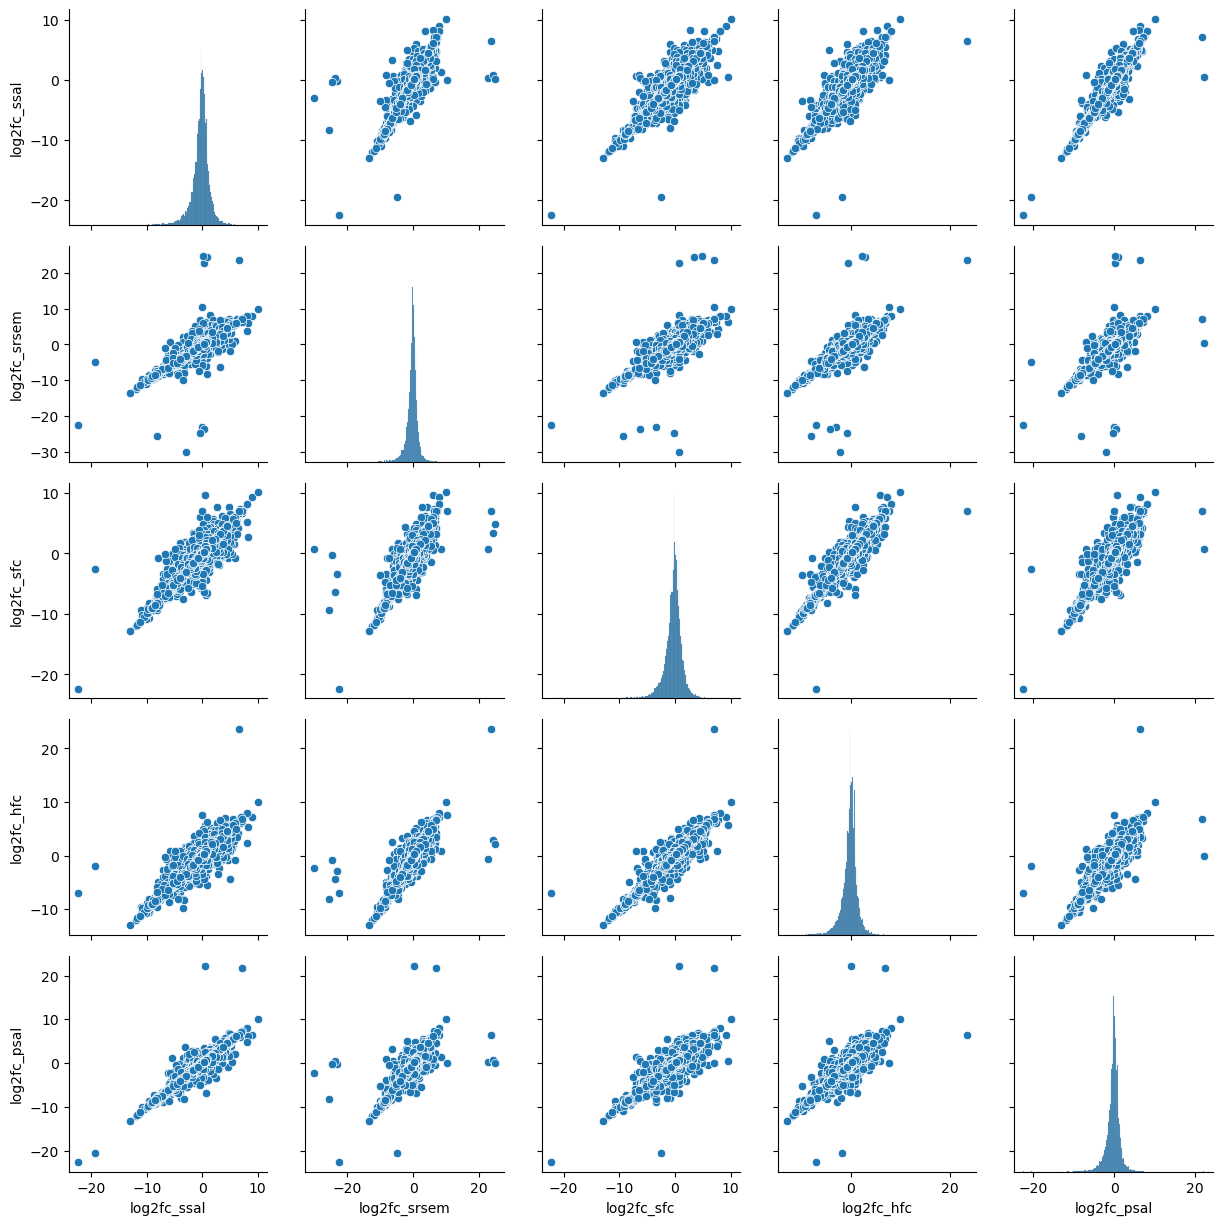

In [38]:
# Scatterplot Matrix: compare log2 results of all pipeline combinations
#g = sns.PairGrid(hs_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

#g = sns.PairGrid(at_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(at_df_all[at_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

g = sns.PairGrid(dr_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

#### Print statistics comparing pipline outcome (1 vs 1)

In [39]:
def pairwiseTtest(df, col1, col2):
    df_test = df[[col1, col2]].dropna()
    #Calculate the t-test on TWO RELATED samples of scores, a and b.
    #This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
    stats, p = ttest_rel(df_test[col1], df_test[col2], axis=0, nan_policy='propagate', alternative='two-sided')
    return stats, p

In [40]:
def wilcoxonTest(df, col1, col2):
    stats, p = wilcoxon(df[col1], df[col2])
    return stats, p

In [41]:
def onewayAnova2(df, col1, col2):
    stats, p = f_oneway(df[col1].dropna(), df[col2].dropna())
    return stats, p

In [42]:
# mean standard error log2fc
def printStat(df, col1, col2):
    print('{} vs {}'.format(col1, col2 ))
    df = df.fillna(0)
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
# r2 to reference line (ercc data)
    #r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    #r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
    msqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
# print regression params
    print('linReg y = {:.3}x + ({:.3})'.format(a,b))
    print(f'linReg R Squared: {reg.score(x,y):.3}')
    print('Reference Root Mean Squared Error: {:.3}'.format(msqerr))
# print p-value pairwise t-test
    stats, p = pairwiseTtest(df, col1, col2)
    print(f'pairwise t-test p = {p:.4}')
# print p-value wilcoxon test
    stats_w, p_w = wilcoxonTest(df, col1, col2)
    print(f'wilcoxon test p = {p_w:.4}')
# print p-value oneway Anova
    stats_a, p_a = onewayAnova2(df, col1, col2)
    print(f'oneway Anova p = {p_a:.4}')
    print('')

In [43]:
def comparePipelines(df):
    printStat(df, 'log2fc_ssal', 'log2fc_srsem')
    printStat(df, 'log2fc_ssal', 'log2fc_sfc')
    printStat(df, 'log2fc_ssal', 'log2fc_hfc')
    printStat(df, 'log2fc_ssal', 'log2fc_psal')
    printStat(df, 'log2fc_srsem', 'log2fc_sfc')
    printStat(df, 'log2fc_srsem', 'log2fc_hfc')
    printStat(df, 'log2fc_srsem', 'log2fc_psal')
    printStat(df, 'log2fc_sfc', 'log2fc_hfc')
    printStat(df, 'log2fc_sfc', 'log2fc_psal')
    printStat(df, 'log2fc_hfc', 'log2fc_psal')

In [44]:
# Print 
#comparePipelines(hs_df_all[~hs_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(hs_df_all)

#comparePipelines(at_df_all[~at_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(at_df_all[at_df_all['gene_id'].isin(ercc_ids)])
comparePipelines(at_df_all)

#comparePipelines(dr_df_all[~dr_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(dr_df_all)

log2fc_ssal vs log2fc_srsem
linReg y = 0.929x + (0.00376)
linReg R Squared: 0.851
Reference Root Mean Squared Error: 0.517
pairwise t-test p = 0.1121
wilcoxon test p = 9.339e-07
oneway Anova p = 0.6587

log2fc_ssal vs log2fc_sfc
linReg y = 0.789x + (0.0454)
linReg R Squared: 0.547
Reference Root Mean Squared Error: 0.982
pairwise t-test p = 0.003469
wilcoxon test p = 4.232e-12
oneway Anova p = 0.1344

log2fc_ssal vs log2fc_hfc
linReg y = 0.783x + (0.0457)
linReg R Squared: 0.531
Reference Root Mean Squared Error: 1.01
pairwise t-test p = 0.00557
wilcoxon test p = 2.699e-09
oneway Anova p = 0.1473

log2fc_ssal vs log2fc_psal
linReg y = 0.921x + (0.00405)
linReg R Squared: 0.849
Reference Root Mean Squared Error: 0.521
pairwise t-test p = 0.07266
wilcoxon test p = 0.03397
oneway Anova p = 0.6143

log2fc_srsem vs log2fc_sfc
linReg y = 0.75x + (0.0543)
linReg R Squared: 0.501
Reference Root Mean Squared Error: 1.04
pairwise t-test p = 0.0003982
wilcoxon test p = 0.01147
oneway Anova p = 0.

### Pipelines: concordant and non-concordant genes

In [45]:
# dataframe of non-concordant genes
hs_nonconc_all = hs_df_all[~hs_df_all['compareDE'].isin(('11111', '00000'))]
hs_conc_all = hs_df_all[hs_df_all['compareDE'].isin(('11111', '00000'))]
at_nonconc_all = at_df_all[~at_df_all['compareDE'].isin(('11111', '00000'))]
at_conc_all = at_df_all[at_df_all['compareDE'].isin(('11111', '00000'))]
dr_nonconc_all = dr_df_all[~dr_df_all['compareDE'].isin(('11111', '00000'))]
dr_conc_all = dr_df_all[dr_df_all['compareDE'].isin(('11111', '00000'))]

In [46]:
def drawConc(conc_df, nonconc_df, param, ymin, ymax):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    sns.violinplot(data=conc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]], 
                   inner="quartile", bw=.15, ax=ax0)
    sns.violinplot(data=nonconc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]], 
                   inner="quartile", bw=.15, ax=ax1)
    ax0.set(ylim=(ymin, ymax))
    ax0.set_title(param+' distribution \n concordant genes')
    ax0.set_xlabel('pipeline setting')
    ax0.set_ylabel(param)
    ax0.yaxis.grid(True)
    ax1.set(ylim=(ymin, ymax))
    ax1.set_title(param+' distribution \n non-concordant genes')
    ax1.set_xlabel('pipeline setting')
    ax1.set_ylabel(param)
    ax1.yaxis.grid(True)

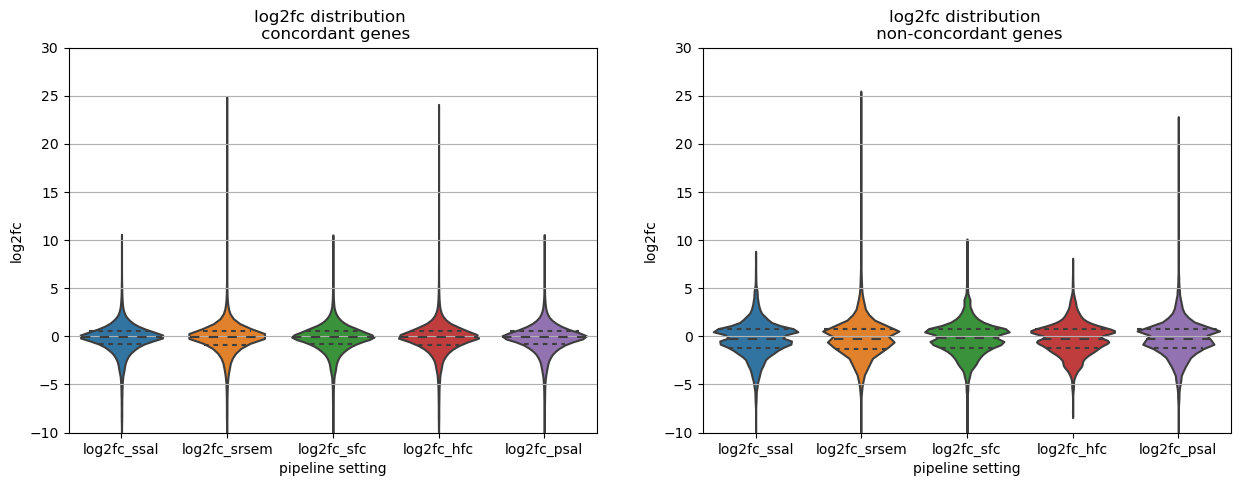

In [47]:
#drawConc(hs_conc_all, hs_nonconc_all,'log2fc', -25, 25)
#drawConc(at_conc_all, at_nonconc_all, 'log2fc', -10, 30)
drawConc(dr_conc_all, dr_nonconc_all, 'log2fc', -10, 30)

In [48]:
def tukeykramer(conc_df, nonconc_df, param):
    conc = conc_df[["gene_id",param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().rename(columns={param+"_ssal":"conc_ssal", param+"_srsem":"conc_srsem", param+"_sfc":"conc_sfc", param+"_hfc":"conc_hfc", param+"_psal":"conc_psal"}).set_index("gene_id")
    nonc = nonconc_df[["gene_id",param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().rename(columns={param+"_ssal":"nonc_ssal", param+"_srsem":"nonc_srsem", param+"_sfc":"nonc_sfc", param+"_hfc":"nonc_hfc", param+"_psal":"nonc_psal"}).set_index("gene_id")
    # Tukey-Kramer test (scipy.stats.tukey_hsd)
    # Tukey’s honestly significant difference (HSD) test performs pairwise comparison of means for a set of samples.
    #from scipy.stats import tukey_hsd

    # stack and join dataframes
    conc.columns.name = 'params'
    stack_conc = conc.stack()
    stack_conc.name = param
    stack_conc.reset_index()

    nonc.columns.name = 'params'
    stack_nonc = nonc.stack()
    stack_nonc.name = param
    stack_nonc.reset_index()

    stack_conc_df = pd.DataFrame(stack_conc).reset_index()
    stack_nonc_df = pd.DataFrame(stack_nonc).reset_index()
    stack_df = stack_conc_df.append(stack_nonc_df)

    # perform Tukey test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    tukey = pairwise_tukeyhsd(endog=stack_df[param],
                              groups=stack_df['params'],
                              alpha=0.05)
    print(tukey)


In [49]:
#from scipy.stats import f_oneway
#The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
#The test is applied to samples from two or more groups, possibly with differing sizes.
#scipy.stats.f_oneway(*args, axis=0)[source]
def onewayANOVA(conc_df, nonconc_df, param):
    # concordant genes inner correlation
    stat1, p1 = f_oneway(conc_df[param+"_ssal"].dropna(), conc_df[param+"_srsem"].dropna(), conc_df[param+"_sfc"].dropna(), conc_df[param+"_hfc"].dropna(), conc_df[param+"_psal"].dropna())
    stat2, p2 = f_oneway(nonconc_df[param+"_ssal"].dropna(), nonconc_df[param+"_srsem"].dropna(), nonconc_df[param+"_sfc"].dropna(), nonconc_df[param+"_hfc"].dropna(), nonconc_df[param+"_psal"].dropna())

    # concordant vs non-concordant by pipeline
    stat3, p3 = f_oneway(conc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna(),
                         nonconc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna())
    # all samples
    stat4, p4 = f_oneway(conc_df[param+"_ssal"].dropna(), conc_df[param+"_srsem"].dropna(), conc_df[param+"_sfc"], conc_df[param+"_hfc"], conc_df[param+"_psal"].dropna(), nonconc_df[param+"_ssal"].dropna(), nonconc_df[param+"_srsem"].dropna(), nonconc_df[param+"_sfc"], nonconc_df[param+"_hfc"], nonconc_df[param+"_psal"].dropna())

    print(' concordant genes all pipelines: {} \n non-concordant genes all pipelines: {}'.format(p1, p2))
    print('concordant vs non-concordant:\n starSal: {} \n starRsem: {} \n starFc: {} \n hisatFC: {} \n pseudoSal: {} '.format(p3[0], p3[1], p3[2], p3[3], p3[4]))
    print('all: {}'.format(p4))

In [50]:
#onewayANOVA(hs_conc_all, hs_nonconc_all, 'log2fc')
#onewayANOVA(at_conc_all, at_nonconc_all, 'log2fc')
onewayANOVA(dr_conc_all, dr_nonconc_all, 'log2fc')

 concordant genes all pipelines: 0.9983244835673242 
 non-concordant genes all pipelines: 0.5294108297541253
concordant vs non-concordant:
 starSal: 0.5992869018846154 
 starRsem: 0.3065407311225872 
 starFc: 0.1297250599386183 
 hisatFC: 0.5914073632124062 
 pseudoSal: 0.8843971558173938 
all: 0.8837256669436832


In [51]:
# tukeykramer(hs_conc_all, hs_nonconc_all, 'log2fc')
#tukeykramer(at_conc_all, at_nonconc_all, 'log2fc')
tukeykramer(dr_conc_all, dr_nonconc_all, 'log2fc')

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  conc_hfc  conc_psal   0.0079    1.0  -0.044 0.0597  False
  conc_hfc   conc_sfc   0.0032    1.0 -0.0486 0.0551  False
  conc_hfc conc_srsem   0.0044    1.0 -0.0474 0.0562  False
  conc_hfc  conc_ssal   0.0072    1.0 -0.0447  0.059  False
  conc_hfc   nonc_hfc   0.0176    1.0 -0.0884 0.1236  False
  conc_hfc  nonc_psal    0.003    1.0 -0.1031  0.109  False
  conc_hfc   nonc_sfc   0.0529 0.8583 -0.0531  0.159  False
  conc_hfc nonc_srsem  -0.0315 0.9951 -0.1376 0.0745  False
  conc_hfc  nonc_ssal  -0.0103    1.0 -0.1163 0.0957  False
 conc_psal   conc_sfc  -0.0046    1.0 -0.0565 0.0472  False
 conc_psal conc_srsem  -0.0035    1.0 -0.0553 0.0484  False
 conc_psal  conc_ssal  -0.0007    1.0 -0.0525 0.0511  False
 conc_psal   nonc_hfc   0.0097    1.0 -0.0963 0.1158  False
 conc_psal  nonc_psal  -0.0049    1.0 -0

### lenght distribution stats (concordant vs non-concordant)

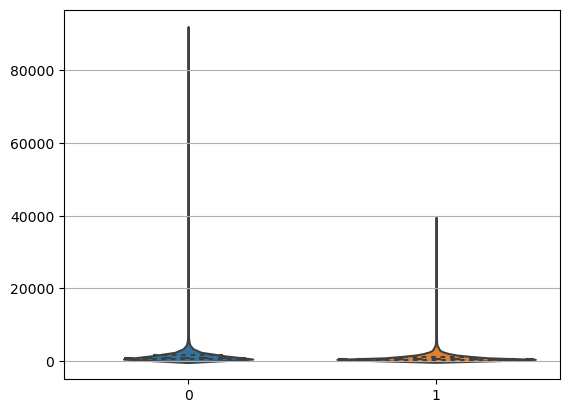

In [52]:
fig, ax = plt.subplots()
sns.violinplot(data=(hs_conc_all['length_mean'], hs_nonconc_all['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(at_conc_all['length_mean'], at_nonconc_all['length_mean']), inner="quartile", bw=.15)
ax.yaxis.grid(True)

In [53]:
# statistical description
def printStats(conc_df, nonconc_df, param):
    print('concordant: ',describe(conc_df[param].dropna(0)), '\n')
    print('non-concordant: ',describe(nonconc_df[param].dropna(0)), '\n')
    
# independent t-test
def printIndieT(conc_df, nonconc_df, param):
    F, p = ttest_ind(conc_df[param].dropna(), nonconc_df[param].dropna())
    print('p = ', p,'\n', 'Ft = ',F)
    
# Mann-Whitney-U-test (non-parametric, no normal distribution)
def printMWU(conc_df, nonconc_df, param):
    F, p = mannwhitneyu(conc_df[param].dropna(), nonconc_df[param].dropna())
    print('p = ', p,'\n', 'Ft = ',F)

In [54]:
#printStats(hs_conc_all, hs_nonconc_all, 'length_mean')
#printIndieT(hs_conc_all, hs_nonconc_all, 'length_mean')
printStats(at_conc_all, at_nonconc_all, 'length_mean')
printIndieT(at_conc_all, at_nonconc_all, 'length_mean')
#printMWU(at_conc_all, at_nonconc_all, 'length_mean')

concordant:  DescribeResult(nobs=21847, minmax=(69.0, 16518.0), mean=1753.7735615874033, variance=984423.7523029009, skewness=2.394084664539088, kurtosis=14.968209930764196) 

non-concordant:  DescribeResult(nobs=1301, minmax=(71.0, 6891.0), mean=1634.8970023059185, variance=754256.2478448531, skewness=1.5383522015447464, kurtosis=4.57762218874907) 

p =  2.3854576654311577e-05 
 Ft =  4.226233193117359


### exon number stats (concordant vs non-concordant)

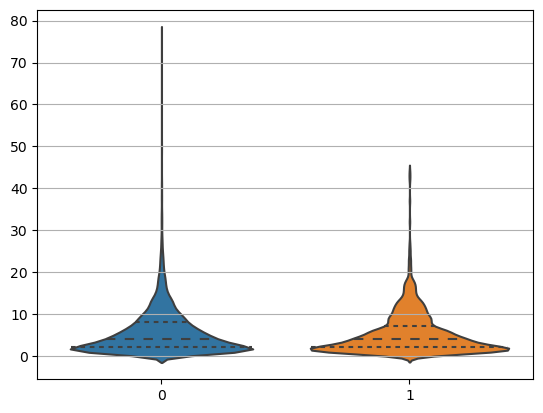

In [55]:
fig, ax = plt.subplots()
#sns.violinplot(data=(hs_conc_all['exons'], hs_nonconc_all['exons']), inner="quartile", bw=.15)
sns.violinplot(data=(at_conc_all['exons'], at_nonconc_all['exons']), inner="quartile", bw=.15)
ax.yaxis.grid(True)

In [56]:
#printStats(hs_conc_all, hs_nonconc_all, 'exons')
#printIndieT(hs_conc_all, hs_nonconc_all, 'exons')
printStats(at_conc_all, at_nonconc_all, 'exons')
printIndieT(at_conc_all, at_nonconc_all, 'exons')
#printMWU(at_conc_all, at_nonconc_all, 'exons')

concordant:  DescribeResult(nobs=21847, minmax=(0.0, 77.0), mean=5.591934819426008, variance=28.756344361218662, skewness=2.541757188771299, kurtosis=12.443931378149681) 

non-concordant:  DescribeResult(nobs=1301, minmax=(0.0, 44.0), mean=5.326671790930054, variance=25.35397268373441, skewness=2.3260340451864767, kurtosis=9.494626945309145) 

p =  0.08202274111861914 
 Ft =  1.7391439449941137


### baseMean stats 

baseMean is the average of the normalized count values, dividing by size factors, taken over all samples, normalizing for sequencing depth. It does not take into account gene length. The base mean is used in DESeq2 only for estimating the dispersion of a gene (it is used to estimate the fitted dispersion). For this task, the range of counts for a gene is relevant but not the gene's length (or other technical factors influencing the count, like sequence content)
https://www.researchgate.net/post/Is-it-correct-to-use-DESeq2s-baseMean-for-interpretation-of-transcript-expression-across-all-samples

baseMean is the average mean expression stat = log2FoldChange/ lfcSE (standard error value)

Use of baseMean in DESeq2 is also explained here: 
https://hbctraining.github.io/DGE_workshop/lessons/04_DGE_DESeq2_analysis.html

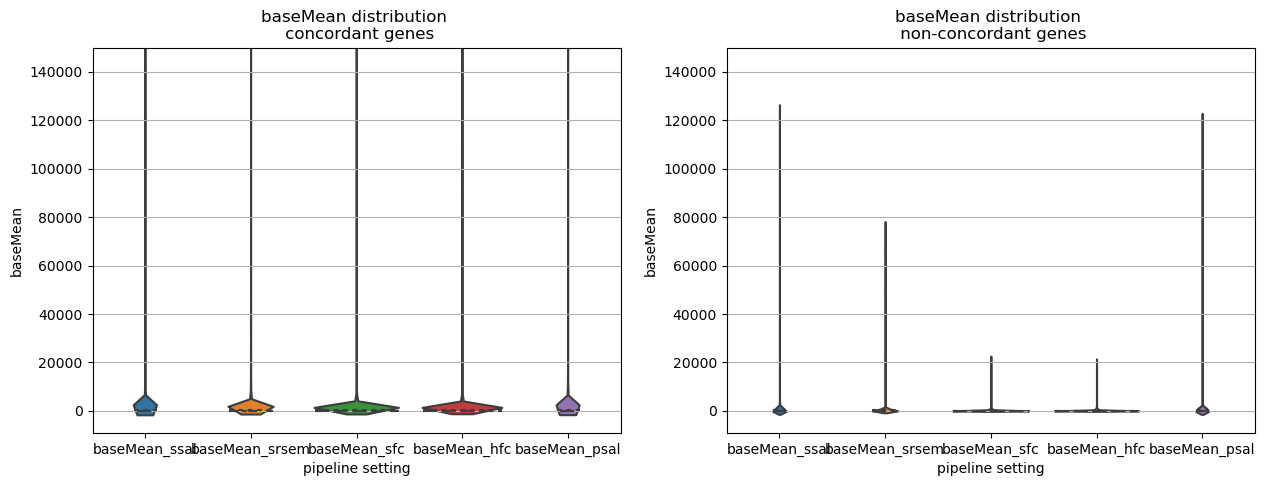

In [57]:
#drawConc(hs_conc_all, hs_nonconc_all,'baseMean', -9000, 150000)
#drawConc(at_conc_all, at_nonconc_all, 'baseMean', -9000, 150000)
drawConc(dr_conc_all, dr_nonconc_all, 'baseMean', -9000, 150000)

In [58]:
#onewayANOVA(hs_conc_all, hs_nonconc_all, 'baseMean')
#onewayANOVA(at_conc_all, at_nonconc_all, 'baseMean')
onewayANOVA(dr_conc_all, dr_nonconc_all, 'baseMean')

 concordant genes all pipelines: 0.008690398507207108 
 non-concordant genes all pipelines: 3.793135497250191e-19
concordant vs non-concordant:
 starSal: 0.872322729383403 
 starRsem: 0.015705570458403137 
 starFc: 8.35848774426311e-08 
 hisatFC: 1.229376668332182e-07 
 pseudoSal: 0.8725157059361757 
all: 1.526004563834746e-13


In [59]:
#tukeykramer(hs_conc_all, hs_nonconc_all, 'baseMean')
#tukeykramer(at_conc_all, at_nonconc_all, 'baseMean')
tukeykramer(dr_conc_all, dr_nonconc_all, 'baseMean')

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff p-adj    lower      upper   reject
------------------------------------------------------------------
  conc_hfc  conc_psal  140.1446 0.1736   -24.0939  304.3831  False
  conc_hfc   conc_sfc   50.3436 0.9939  -113.8949  214.5822  False
  conc_hfc conc_srsem   38.2342 0.9993  -126.0043  202.4727  False
  conc_hfc  conc_ssal  164.3991 0.0495     0.1605  328.6376   True
  conc_hfc   nonc_hfc -479.2119 0.0003  -817.1155 -141.3084   True
  conc_hfc  nonc_psal  159.4788 0.8953  -178.4248  497.3823  False
  conc_hfc   nonc_sfc  -463.327 0.0006  -801.2305 -125.4234   True
  conc_hfc nonc_srsem -202.5301 0.6718  -540.4336  135.3735  False
  conc_hfc  nonc_ssal  144.5825 0.9409   -193.321  482.4861  False
 conc_psal   conc_sfc   -89.801 0.7786  -254.0395   74.4375  False
 conc_psal conc_srsem -101.9104 0.6252  -266.1489   62.3281  False
 conc_psal  conc_ssal   24.2545    1.0  -139.9841   188.493  F

### Differences between single identified (one pipeline) and all identified DE genes (all pipelines) - compare VennDiagrams

In [60]:
#separate single identified genes from all identified
single = ['10000', '01000', '00100', '00010', '00001']

at_single_df = at_df_all[at_df_all['compareDE'].isin(single)]
at_allde_df = at_df_all[at_df_all['compareDE']=='11111']

hs_single_df = hs_df_all[hs_df_all['compareDE'].isin(single)]
hs_allde_df = hs_df_all[hs_df_all['compareDE']=='11111']

dr_single_df = dr_df_all[dr_df_all['compareDE'].isin(single)]
dr_allde_df = dr_df_all[dr_df_all['compareDE']=='11111']

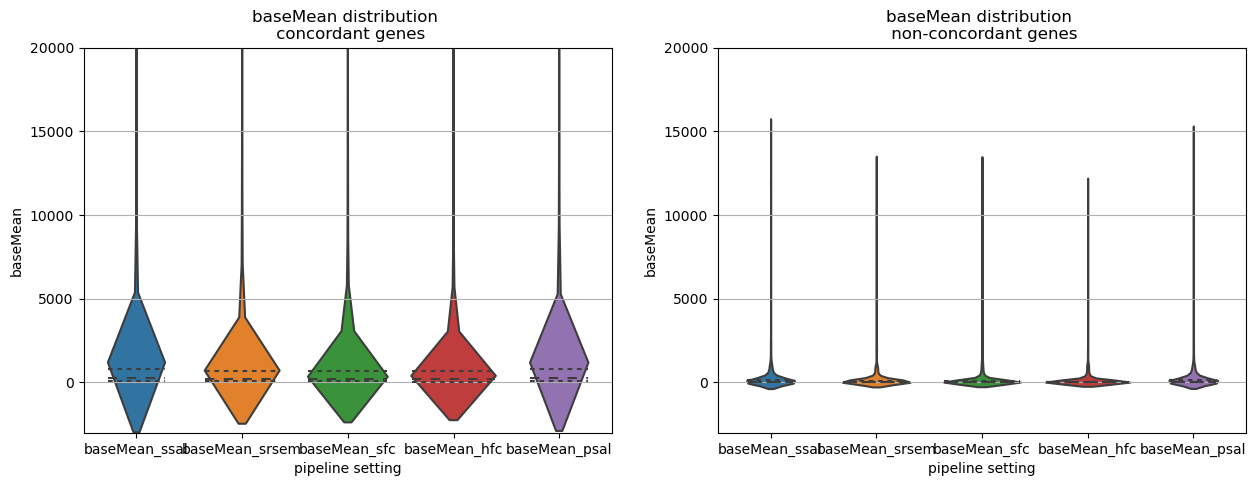

In [61]:
# Gene Length
#drawConc(at_allde_df, at_single_df, 'baseMean', -3000, 20000)
#drawConc(hs_allde_df, hs_single_df, 'baseMean', -10000, 50000)
drawConc(dr_allde_df, dr_single_df, 'baseMean', -3000, 20000)
#at_single_df.columns

In [62]:
print('ANOVA: baseMean')
print(' \n Arabidopsis dataset:')
onewayANOVA(at_allde_df, at_single_df, 'baseMean')
print(' \n Human cell dataset:')
onewayANOVA(hs_allde_df, hs_single_df, 'baseMean')
print('\n Zebrafish dataset:')
onewayANOVA(dr_allde_df, dr_single_df, 'baseMean')

ANOVA: baseMean
 
 Arabidopsis dataset:
 concordant genes all pipelines: 0.14669204627930313 
 non-concordant genes all pipelines: 0.8149824477041789
concordant vs non-concordant:
 starSal: 4.048310090059478e-09 
 starRsem: 5.764980613339648e-09 
 starFc: 2.2210070900313254e-09 
 hisatFC: 2.324870473127299e-09 
 pseudoSal: 5.607057152052244e-09 
all: 2.8588919964164548e-34
 
 Human cell dataset:
 concordant genes all pipelines: 1.9454242280595422e-38 
 non-concordant genes all pipelines: 1.0352787161148864e-06
concordant vs non-concordant:
 starSal: 1.180901692389361e-08 
 starRsem: 1.5598929082450905e-08 
 starFc: 4.4828349082176264e-09 
 hisatFC: 7.691821696827436e-09 
 pseudoSal: 1.1358622784522312e-08 
all: 4.154038284595274e-70

 Zebrafish dataset:
 concordant genes all pipelines: 0.159608824127036 
 non-concordant genes all pipelines: 0.027654471214166535
concordant vs non-concordant:
 starSal: 0.0003570433678951232 
 starRsem: 0.00012771414115325504 
 starFc: 2.6846758060073783e

In [63]:
#tukeykramer(at_allde_df, at_single_df, 'baseMean')
#tukeykramer(hs_allde_df, hs_single_df, 'baseMean')
tukeykramer(dr_allde_df, dr_single_df, 'baseMean')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------
  conc_hfc  conc_psal    266.068 0.6858  -182.7728  714.9088  False
  conc_hfc   conc_sfc   105.1585 0.9992  -343.6823  553.9993  False
  conc_hfc conc_srsem    73.8917    1.0  -374.9491  522.7325  False
  conc_hfc  conc_ssal   318.0496 0.4278  -130.7912  766.8905  False
  conc_hfc   nonc_hfc -1263.1351 0.0127 -2379.6218 -146.6485   True
  conc_hfc  nonc_psal -1122.0636 0.0477 -2238.5503    -5.577   True
  conc_hfc   nonc_sfc -1248.1581 0.0148 -2364.6448 -131.6715   True
  conc_hfc nonc_srsem -1203.3198 0.0229 -2319.8064  -86.8331   True
  conc_hfc  nonc_ssal -1119.0435 0.0489 -2235.5301   -2.5569   True
 conc_psal   conc_sfc  -160.9095 0.9812  -609.7503  287.9313  False
 conc_psal conc_srsem  -192.1763 0.9406  -641.0171  256.6645  False
 conc_psal  conc_ssal    51.9817    1.0  -396.85

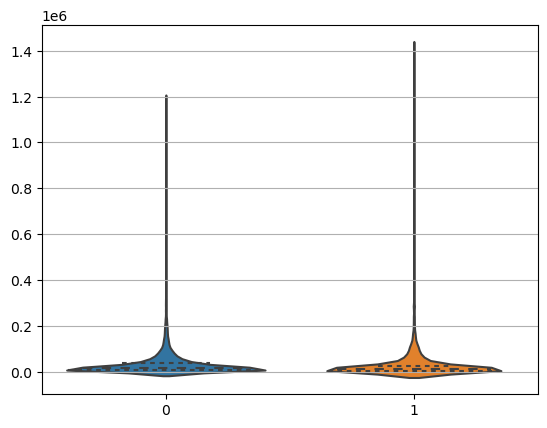

In [64]:
fig, ax = plt.subplots()
#sns.violinplot(data=(at_allde_df['length_mean'], at_single_df['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(hs_allde_df['length_mean'], hs_single_df['length_mean']), inner="quartile", bw=.15)
sns.violinplot(data=(dr_allde_df['length_mean'], dr_single_df['length_mean']), inner="quartile", bw=.15)

ax.yaxis.grid(True)

In [65]:
print('Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:\n')
print('Human cell dataset')
printStats(hs_allde_df, hs_single_df, 'length_mean')
printIndieT(hs_allde_df, hs_single_df, 'length_mean')
print('\n Arabidopsis dataset')
printStats(at_allde_df, at_single_df, 'length_mean')
printIndieT(at_allde_df, at_single_df, 'length_mean')
print('\n Zebrafish dataset')
printStats(dr_allde_df, dr_single_df, 'length_mean')
printIndieT(dr_allde_df, dr_single_df, 'length_mean')

Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:

Human cell dataset
concordant:  DescribeResult(nobs=20969, minmax=(134.0, 91667.0), mean=1731.9241737803425, variance=1868496.0855320636, skewness=15.543614149765908, kurtosis=904.3679560274684) 

non-concordant:  DescribeResult(nobs=1848, minmax=(46.0, 6323.0), mean=910.422619047619, variance=683478.6946045067, skewness=2.3423186969151635, kurtosis=7.585453347281781) 

p =  1.114873787249233e-140 
 Ft =  25.428350901038034

 Arabidopsis dataset
concordant:  DescribeResult(nobs=3691, minmax=(237.0, 9096.0), mean=1788.7174207531834, variance=720222.7334064622, skewness=2.025697374359403, kurtosis=8.726905526852288) 

non-concordant:  DescribeResult(nobs=344, minmax=(71.0, 6191.0), mean=1648.7296511627908, variance=719405.7663485659, skewness=1.383646788579839, kurtosis=3.247963937344484) 

p =  0.003450231736958074 
 Ft =  2.9262208833265584

 Zebrafish dataset
concordant:  D

## ERCC stats (standard vs pipelines)

In [66]:
hs_ercc = ercc_df.merge(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')
at_ercc = ercc_df.merge(at_df_all[at_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')
dr_ercc = ercc_df.merge(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')

In [67]:
hs_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_21_ercc', 'log2fc':'log2fc_ercc'}
at_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_12_ercc', 'log2fc':'log2fc_ercc'}
dr_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_ercc', 'log2fc':'log2fc_21_ercc'}

In [68]:
hs_ercc = hs_ercc.rename(columns=hs_ercc_coldict)
at_ercc = at_ercc.rename(columns=at_ercc_coldict)
dr_ercc = dr_ercc.rename(columns=dr_ercc_coldict)

In [69]:
hs_ercc['outcome_ercc'] = hs_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')
at_ercc['outcome_ercc'] = at_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')
dr_ercc['outcome_ercc'] = dr_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')

In [70]:
print(hs_ercc.shape, at_ercc.shape, dr_ercc.shape)
print(at_starsal[at_starsal['gene_id'].isin(ercc_ids)].shape)
print(at_starrsem[at_starrsem['gene_id'].isin(ercc_ids)].shape)
print(at_starfc[at_starfc['gene_id'].isin(ercc_ids)].shape)
print(at_hisatfc[at_hisatfc['gene_id'].isin(ercc_ids)].shape)
print(at_pseudosal[at_pseudosal['gene_id'].isin(ercc_ids)].shape)


(92, 56) (92, 56) (92, 52)
(92, 10)
(92, 10)
(79, 10)
(79, 10)
(92, 10)


In [71]:
# Enable to enter ax to place graph in subplot
def scatter_bMlim_ax(df_in, col1, col2, baseMean, limit, ax, cmap, scale, title): #col1 is x, col2 is y scale (ercc), scale = scale/none print scale-bar to left
    #fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    df_in = df_in.fillna(0.1)
    #df_in = df_in[df_in[baseMean].dropna()]
    df_in['log2bM'] = df_in[baseMean].apply(lambda x: np.log2(x))
    if (limit == 'all'):
        df = df_in
    #    title = title + ' ' + limit + ' values'
    else:
        df = df_in[df_in['log2bM']>=limit]
        df_non = df_in[df_in['log2bM']<limit]
    #    title = title + '>=' + str(limit)

    cmap= cmap #'cool'

    xmin=df[col2].min()
    xmax=df[col2].max()
    ymin=df[col1].min()
    ymax=df[col1].max()
    vmin=df_in['log2bM'].min()
    vmax=df_in['log2bM'].max()

    #ax.vlines(0, xmin, xmax, colors='black', ls='--', lw=0.7)
    #ax.hlines(0, ymin, ymax, colors='black', ls='--', lw=0.7)
    ax.axline((1, 1), slope=1, c='orange', ls='--', lw=2)
    
    color = df['log2bM']
    #ax0.scatter(A, diff_fcss['A'], c=color, cmap='cool', vmin=ymin, vmax=ymax)
    ax.scatter(df[col1], 
                df[col2],
                c=color, cmap=cmap, vmin=vmin, vmax=vmax, marker='o')
    #scatter non-included values as grey dots if limit not 'all'
    if (limit != 'all'):
        ax.scatter(df_non[col1], df_non[col2], c='grey', marker='.', vmin=vmin, vmax=vmax)
    #ax.set_title(title)# \n Difference in Fold Change Ratio (mix1:mix2, measured minus standard) \n colorscale: log2(transcript concentration mix1)')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    if(col1 == 'log2fc_ssal'):
        ax.set_ylabel('log2fc measured')
    if(col1 == 'log2fc_sfc'):
        ax.set_xlabel('log2fc ercc reference')
    ax.set_title(title)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='grey', ls='--', lw=0.7)
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
    rmsqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
# print regression params
    #ax.text(xmin-0.5, ymax, f'R^2 to regression: {reg.score(x,y):.3}, dx={a:.3}')
    #ax.text(xmin-0.5, ymax-0.5, f'R^2 to ercc: {r2:.3}, shift on x-axis: {-b/a:.3}')
    #ax.text(xmin-0.5, ymax-1.0, f'root meansqerror: {rmsqerr:.3}')
    #ax.text(xmin-0.5, ymax-1.5, f'no of reads: {df.shape[0]}')
    #print('y = {:.3}x + ({:.3})'.format(a,b))
    #print(f'R Squared: {reg.score(x,y):.3}')
    #print('log2 feature counts shift: {:.3}'.format(-b/a))
    #print('Reference R Squared all values: {:.3}'.format(r2_all))
    #print('Reference R Squared filtered values: {:.3}'.format(r2))
    if(scale == 'scale'):
    # set colorbar to legend
    # setup the normalization and the colormap
        normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
        sm = cm.ScalarMappable(norm=normalize, cmap=cmap)
        sm.set_array([])

        fig.colorbar(sm, ax=ax)

In [72]:
def drawLog2Corr(df, bmean, color):
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
    scatter_bMlim_ax(df, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal', bmean, ax0, color, 'none', '3.2 star_salmon')
    scatter_bMlim_ax(df, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_ssal', bmean, ax1, color, 'none', '3.2 star_rsem')
    scatter_bMlim_ax(df, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_ssal', bmean, ax2, color, 'none', '1.4.2 star_fc')
    scatter_bMlim_ax(df, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_ssal', bmean, ax3, color, 'none', '1.4.2 hisat_fc')
    scatter_bMlim_ax(df, 'log2fc_psal', 'log2fc_ercc', 'baseMean_ssal', bmean, ax4, color, 'scale', '3.2 pseudo_salmon')

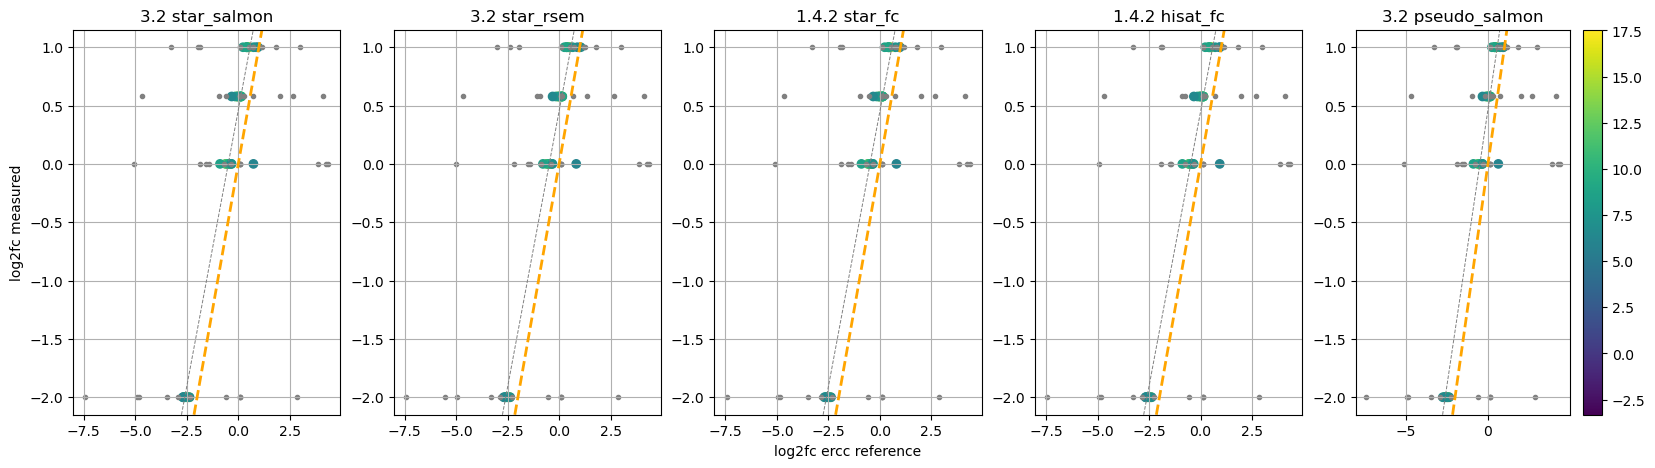

In [73]:
drawLog2Corr(at_ercc, 6, 'viridis')
#drawLog2Corr(hs_ercc, 3, 'cool')
#drawLog2Corr(dr_ercc, 4, 'Blues')

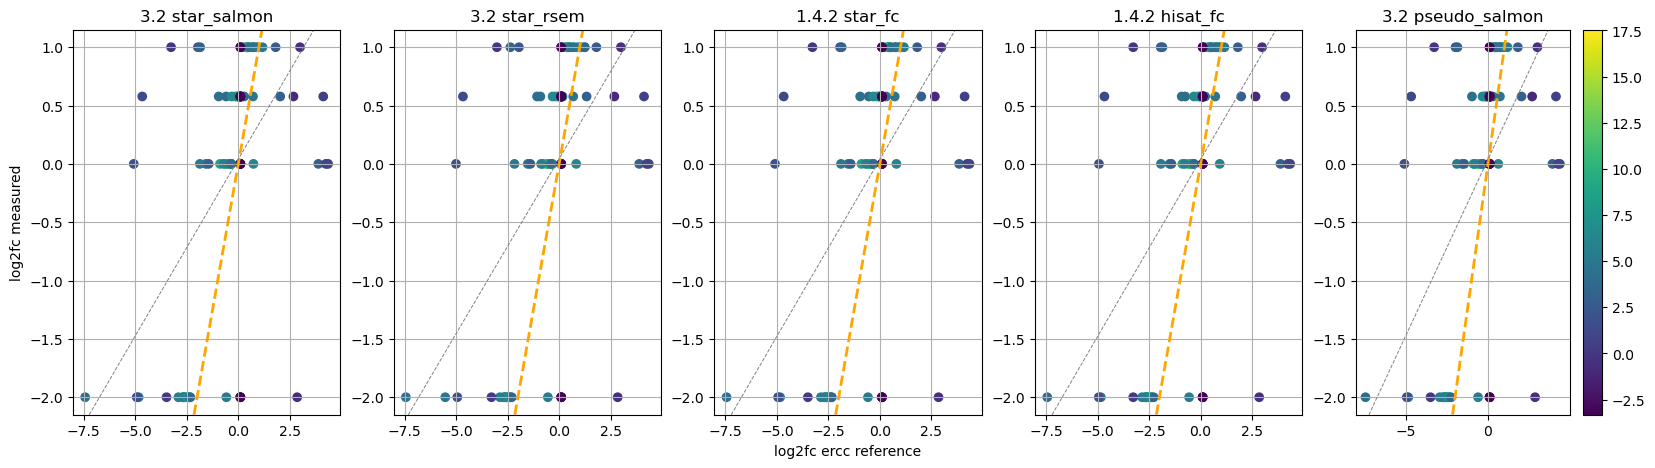

In [74]:
drawLog2Corr(at_ercc, 'all', 'viridis')
#drawLog2Corr(hs_ercc, 'all', 'cool')
#drawLog2Corr(dr_ercc, 'all', 'Blues')
#print(f'hs mean slope x = {np.mean([0.84, 0.84, 0.85, 0.85, 0.79])}')
#print(f'at mean slope x = {np.mean([0.303, 0.3, 0.303, 0.303, 0.303])}')
#print(f'dr mean slope x = {np.mean([0.871, 0.896, 0.877, 0.879, 0.882])}')

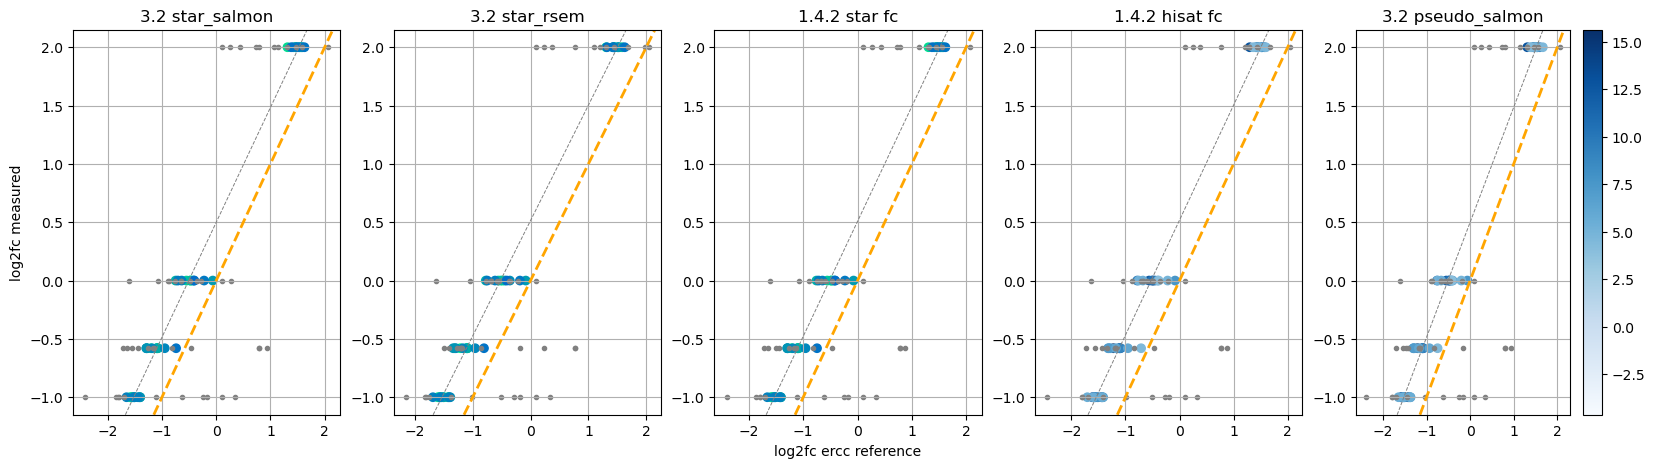

In [75]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
#scatter_bMlim_ax(at_ercc, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal', 5, ax0, 'cool')
#scatter_bMlim_ax(at_ercc, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_ssal', 5, ax1, 'cool')
#scatter_bMlim_ax(at_ercc, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_ssal', 5, ax2, 'cool')
#scatter_bMlim_ax(at_ercc, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_ssal', 5, ax3, 'cool')
#scatter_bMlim_ax(at_ercc, 'log2fc_psal', 'log2fc_ercc', 'baseMean_ssal', 5, ax4, 'cool')

#scatter_bMlim_ax(hs_ercc, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal', 5, ax0, 'viridis')
#scatter_bMlim_ax(hs_ercc, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_ssal', 5, ax1, 'viridis')
#scatter_bMlim_ax(hs_ercc, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_ssal', 5, ax2, 'viridis')
#scatter_bMlim_ax(hs_ercc, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_ssal', 5, ax3, 'viridis')
#scatter_bMlim_ax(hs_ercc, 'log2fc_psal', 'log2fc_ercc', 'baseMean_ssal', 5, ax4, 'viridis')

scatter_bMlim_ax(dr_ercc, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal', 4, ax0, 'winter', 'none', '3.2 star_salmon')
scatter_bMlim_ax(dr_ercc, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_ssal', 4, ax1, 'winter', 'none', '3.2 star_rsem')
scatter_bMlim_ax(dr_ercc, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_ssal', 4, ax2, 'winter', 'none', '1.4.2 star fc')
scatter_bMlim_ax(dr_ercc, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_ssal', 4, ax3, 'Blues', 'none', '1.4.2 hisat fc')
scatter_bMlim_ax(dr_ercc, 'log2fc_psal', 'log2fc_ercc', 'baseMean_ssal', 4, ax4, 'Blues', 'scale', '3.2 pseudo_salmon')

In [76]:
bMdf = pd.DataFrame(['baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'])

def parse_bMlim(df_in, col1, col2, baseMean): #col1 is x, col2 is y scale (ercc)
    #bMdf = pd.DataFrame(['baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'])
    array_out = []
    n = []
    #filter by baseMean
    df_in = df_in.fillna(0.1)
    df_in['log2bM'] = df_in[baseMean].apply(lambda x: np.log2(x))
    for limit in range(0, 15):
        df = df_in[df_in['log2bM']>=limit]
    # fitting the model
        #reg = LinearRegression().fit(x,y)
        n.append(df.shape[0])
    # r2 to reference line (ercc data)
        r2 = sklearn.metrics.r2_score(df[col2], df[col1])
        r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
        rmsqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
        array_out.append(rmsqerr)
    return (array_out, n)
        

In [77]:
def bMtable(df_in):
    bMdf = pd.DataFrame([])
    ssal = parse_bMlim(df_in, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal')
    srsem = parse_bMlim(df_in, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_srsem')
    sfc = parse_bMlim(df_in, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_sfc')
    hfc = parse_bMlim(df_in, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_hfc')
    psal = parse_bMlim(df_in, 'log2fc_psal', 'log2fc_ercc', 'baseMean_psal')
    #'baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'
    #bMdf['baseMean']=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    n=ssal[1]
    bMdf['ssal'] = ssal[0]
    bMdf['srsem'] = srsem[0]
    bMdf['sfc'] = sfc[0]
    bMdf['hfc'] = hfc[0]
    bMdf['psal'] = psal[0]
    
    return bMdf, n
    

In [78]:
def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d

In [79]:
hs_rmsqerr = bMtable(hs_ercc)
at_rmsqerr = bMtable(at_ercc)
dr_rmsqerr = bMtable(dr_ercc)

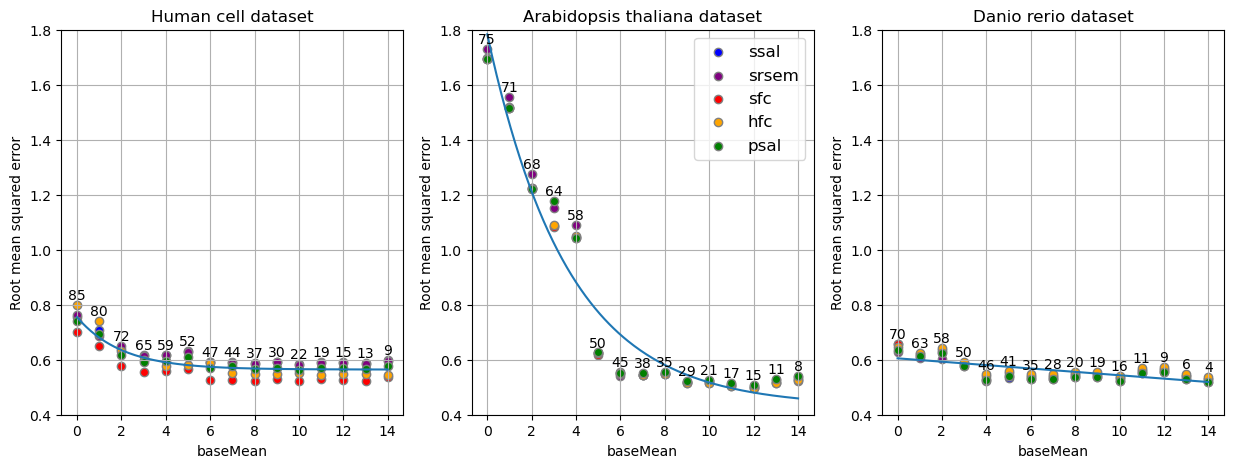

In [80]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
df1 = hs_rmsqerr[0]
df1stack = pd.DataFrame(df1.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
df2 = at_rmsqerr[0]
df2stack = pd.DataFrame(df2.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
df3 = dr_rmsqerr[0]
df3stack = pd.DataFrame(df3.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
l = 0.4
m = 1.8


ax0.scatter(df1.reset_index()['index'], df1['ssal'], c='blue', edgecolors='grey', marker='o', label='ssal')
ax0.scatter(df1.reset_index()['index'], df1['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax0.scatter(df1.reset_index()['index'], df1['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax0.scatter(df1.reset_index()['index'], df1['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax0.scatter(df1.reset_index()['index'], df1['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax0.yaxis.grid(True)
ax0.xaxis.grid(True)
ax0.set_ylabel('Root mean squared error')
ax0.set_xlabel('baseMean')
ax0.set_title('Human cell dataset')
ax0.set_ylim(l,m)
# add labels (number of erccs included)
values = hs_rmsqerr[0].max(axis=1)
labels = hs_rmsqerr[0].index
text =hs_rmsqerr[1]
for i, v in enumerate(values):
    ax0.text(i, v+0.02, text[i], ha="center")
xx = np.linspace(0, 14, 200)
#fit exponential function
y_hs_stack = df1stack['y']
x_hs_stack = df1stack['x']
popt_hs, pcov_hs = curve_fit(exp_func, x_hs_stack, y_hs_stack, p0=(1, 1e-6, 1))
y_hs = exp_func(xx, *popt_hs)
ax0.plot(xx, y_hs)

ax1.scatter(df2.reset_index()['index'], df2['ssal'], c='blue', edgecolors='grey', marker='o', label='ssal')
ax1.scatter(df2.reset_index()['index'], df2['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax1.scatter(df2.reset_index()['index'], df2['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax1.scatter(df2.reset_index()['index'], df2['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax1.scatter(df2.reset_index()['index'], df2['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_ylabel('Root mean squared error')
ax1.set_xlabel('baseMean')
ax1.set_title('Arabidopsis thaliana dataset')
ax1.set_ylim(l,m)
# add labels (number of erccs included)
values_at = at_rmsqerr[0].max(axis=1)
labels_at = at_rmsqerr[0].index
text_at = at_rmsqerr[1]
for i, v in enumerate(values_at):
    #print(i)
    ax1.text(i, v+0.02, text_at[i], ha="center")
#fit exponential functiony_hs_stack = df1stack['y']
x_at_stack = df2stack['x']
y_at_stack = df2stack['y']
popt_at, pcov_at = curve_fit(exp_func, x_at_stack, y_at_stack, p0=(1, 1e-6, 1))
y_at = exp_func(xx, *popt_at)
ax1.plot(xx, y_at)

ax1.legend(loc="upper right", fontsize=12)

ax2.scatter(df3.reset_index()['index'], df3['ssal'], c='blue', edgecolors='grey', marker='o', label='ssal')
ax2.scatter(df3.reset_index()['index'], df3['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax2.scatter(df3.reset_index()['index'], df3['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax2.scatter(df3.reset_index()['index'], df3['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax2.scatter(df3.reset_index()['index'], df3['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_ylabel('Root mean squared error')
ax2.set_xlabel('baseMean')
ax2.set_title('Danio rerio dataset')
ax2.set_ylim(l,m)
# add labels (number of erccs included)
values_dr = dr_rmsqerr[0].max(axis=1)
labels_dr = dr_rmsqerr[0].index
text_dr = dr_rmsqerr[1]
for i, v in enumerate(values_dr):
    #print(i)
    ax2.text(i, v+0.02, text_dr[i], ha="center")
#fit exponential functiony_hs_stack = df1stack['y']
x_dr_stack = df3stack['x']
y_dr_stack = df3stack['y']
popt_dr, pcov_dr = curve_fit(exp_func, x_dr_stack, y_dr_stack, p0=(1, 1e-6, 1))
y_dr = exp_func(xx, *popt_dr)
ax2.plot(xx, y_dr)

#ax2.legend(loc="upper right", fontsize=12)

In [81]:
def compareLog2fc_ax(df, pipe1, pipe2, ax, legend):
    de = df[(df['outcome_'+pipe1]=='DE') & (df['outcome_'+pipe2]=='DE')].fillna(0)
    not_de = df[(df['outcome_'+pipe1]=='not_DE') & (df['outcome_'+pipe2]=='not_DE')].fillna(0)
    de_only1 = df[(df['outcome_'+pipe1]=='DE') & (df['outcome_'+pipe2]=='not_DE')].fillna(0)
    de_only2 = df[(df['outcome_'+pipe1]=='not_DE') & (df['outcome_'+pipe2]=='DE')].fillna(0)
    
    l = min(df['log2fc_'+pipe1].min(), df['log2fc_'+pipe2].min())-0.5
    m = max(df['log2fc_'+pipe1].max(), df['log2fc_'+pipe2].max())+0.5
    
    ax.scatter(not_de['log2fc_'+pipe1], 
                not_de['log2fc_'+pipe2],
               c='grey', edgecolors='black', marker='.', label='not DE')
    ax.scatter(de_only1['log2fc_'+pipe1], 
                de_only1['log2fc_'+pipe2],
               c='limegreen', edgecolors='blue', marker='v', label='only DE '+pipe1)
    ax.scatter(de_only2['log2fc_'+pipe1], 
                de_only2['log2fc_'+pipe2],
               c='limegreen', edgecolors='green', marker='v', label='only DE '+pipe2)
    ax.scatter(de['log2fc_'+pipe1], 
                de['log2fc_'+pipe2],
               c='darkorange', edgecolors='red', marker='o', label='DE')
    #ax.set_title('Log2 foldchange '+pipe1+' vs. '+pipe2)# \n Difference in Fold Change Ratio (mix1:mix2, measured minus standard) \n colorscale: log2(transcript concentration mix1)')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(pipe1)
    ax.set_xlabel(pipe2)
    #ax.set_xlim(l,m)
    #ax.set_ylim(l,m)
    ax.vlines(0, l, m, colors='black')
    ax.hlines(0, l, m, colors='black')
    ax.axline((1, 1), slope=1, c='yellow', ls='--', lw=1.5)
    ax.set_facecolor("lightgrey")
    if(legend == 'yes'):
        ax.legend(bbox_to_anchor=(-0.3,0.5), loc="lower right", fontsize=12)
        

In [82]:
def nofig(ax):
    ax.set_facecolor("white")
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')

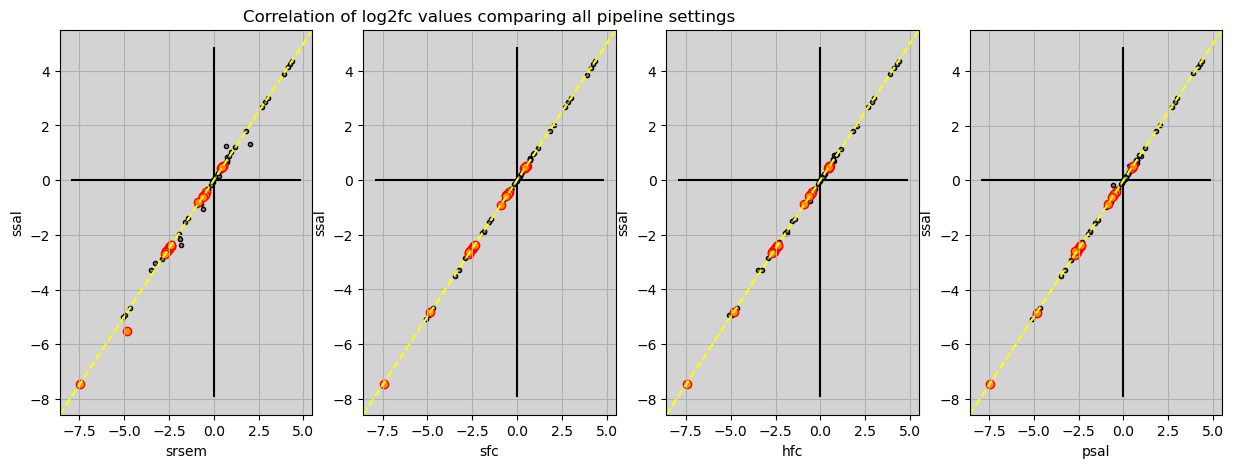

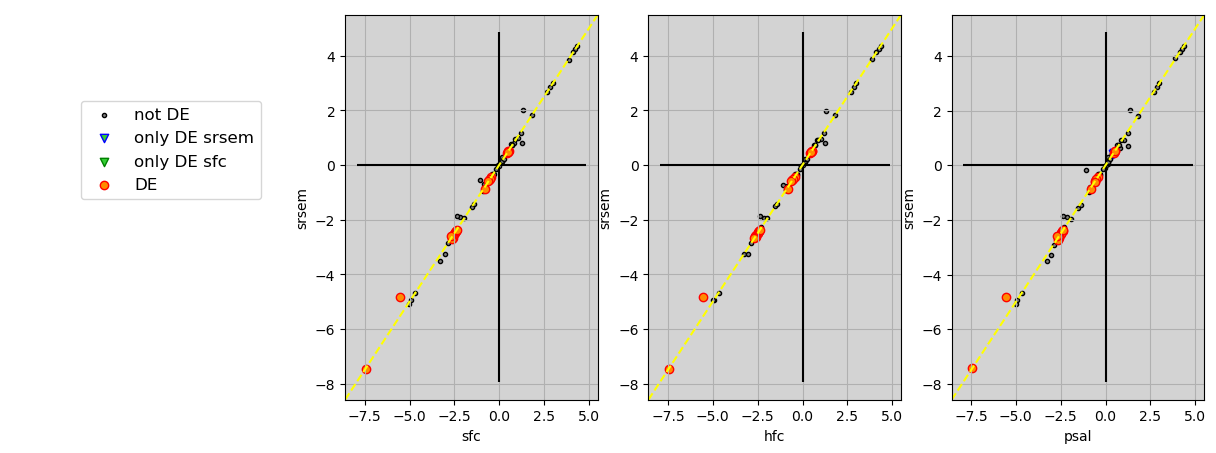

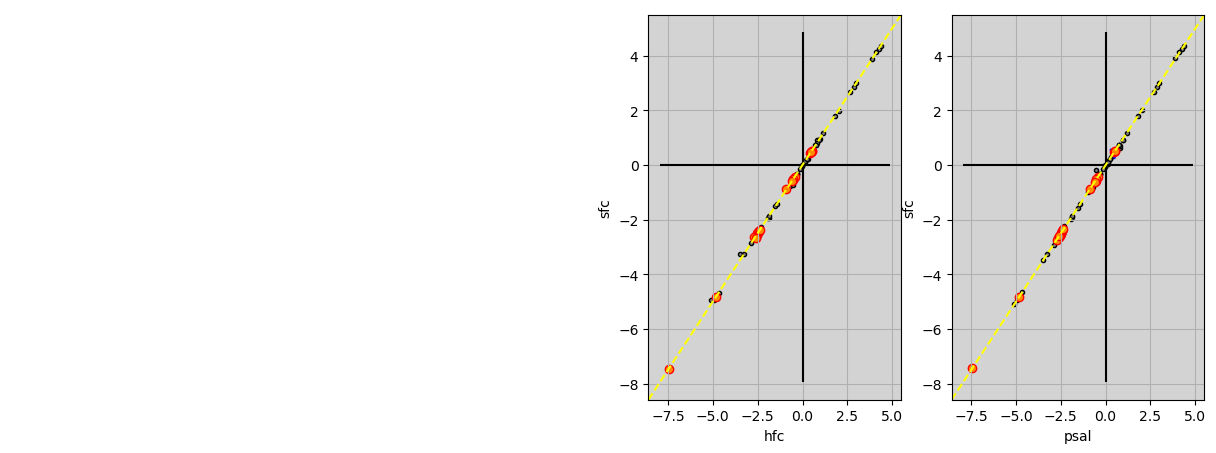

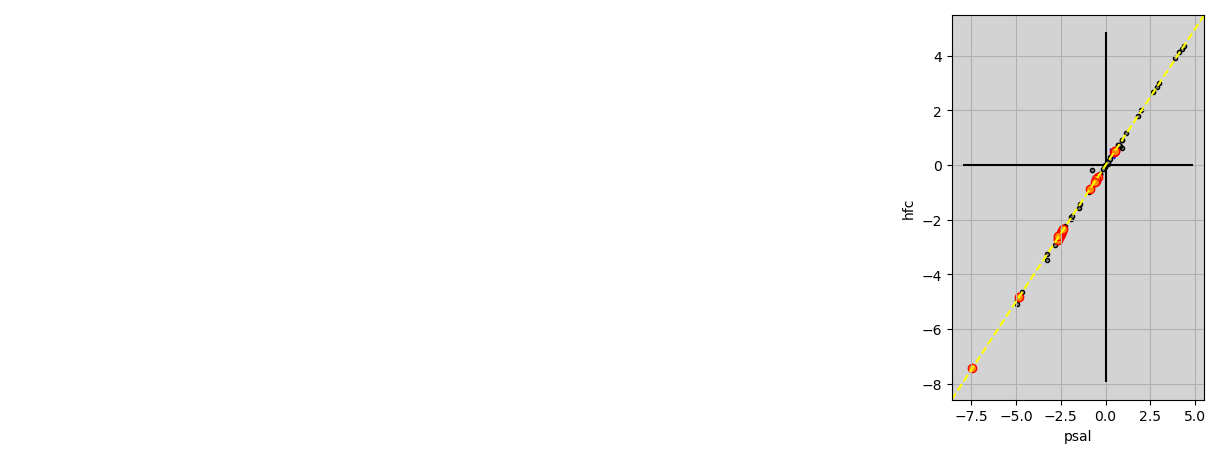

In [83]:
# ARABIDOPSIS THALIANA: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(at_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(at_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(at_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(at_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(at_ercc, 'hfc', 'psal', ax3, 'no')
#ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')


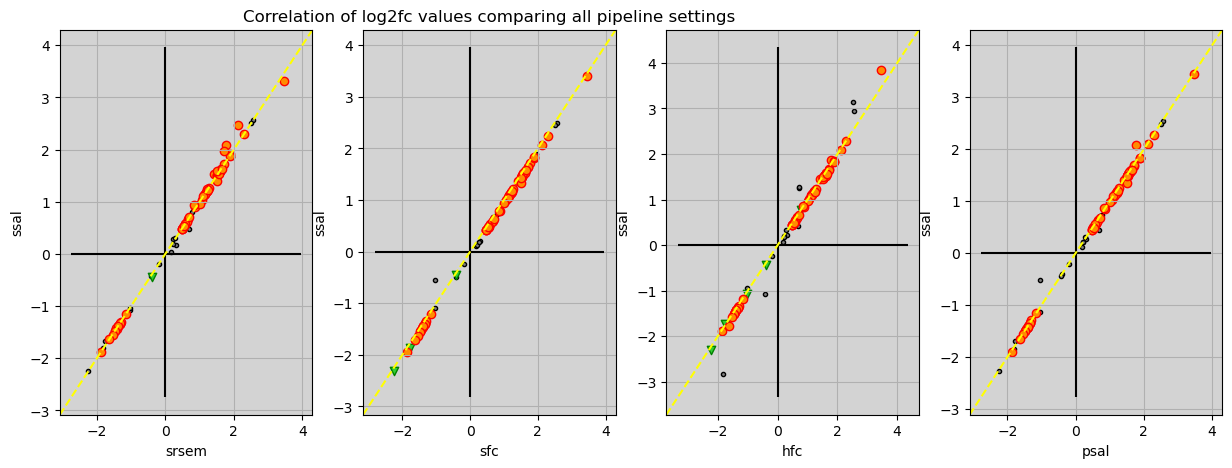

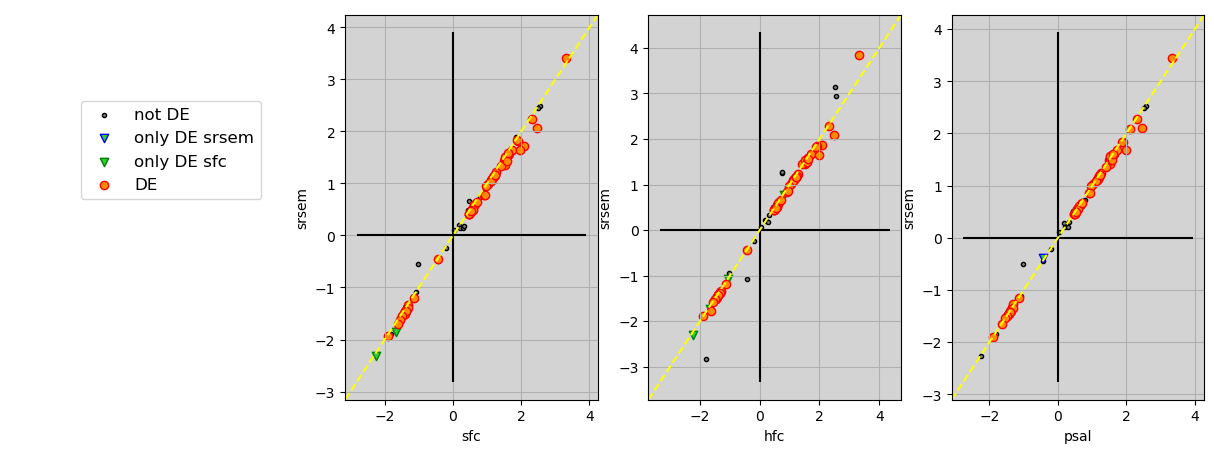

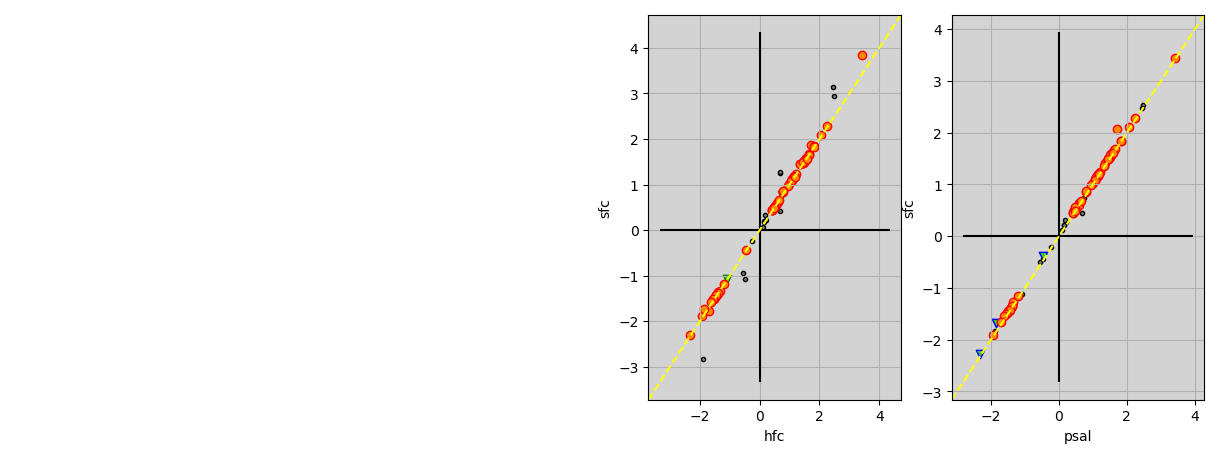

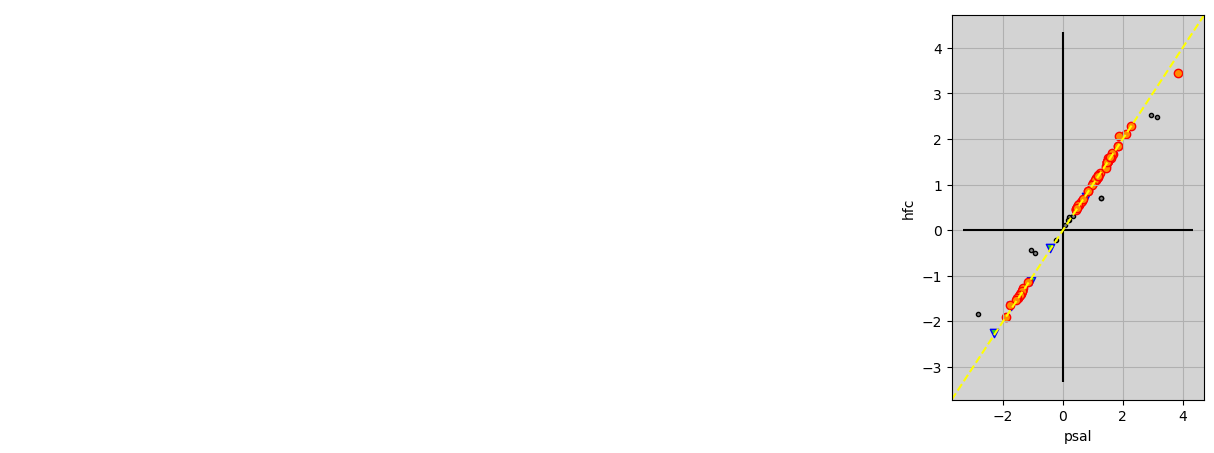

In [84]:
# HOMO SAPIENS: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(hs_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(hs_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(hs_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(hs_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(hs_ercc, 'hfc', 'psal', ax3, 'no')

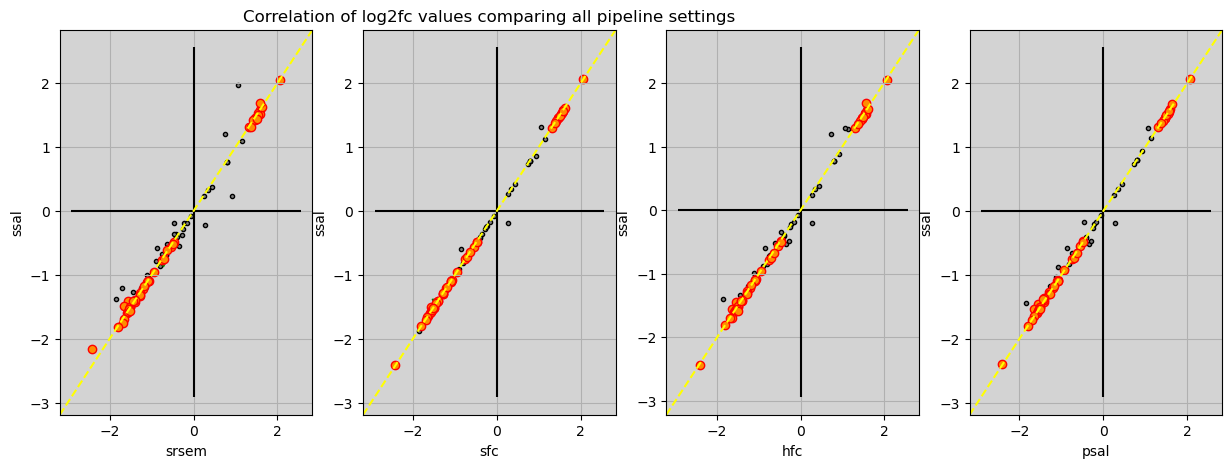

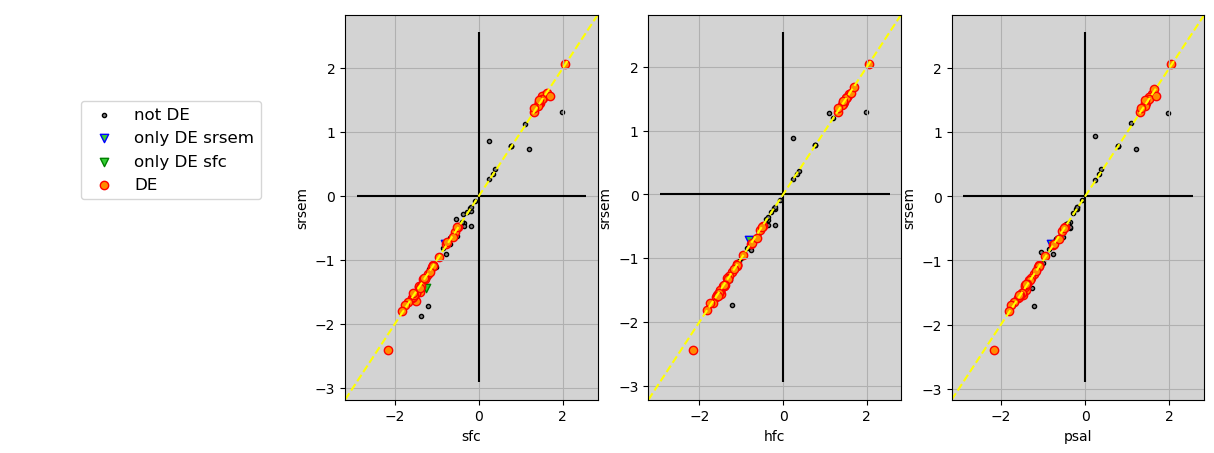

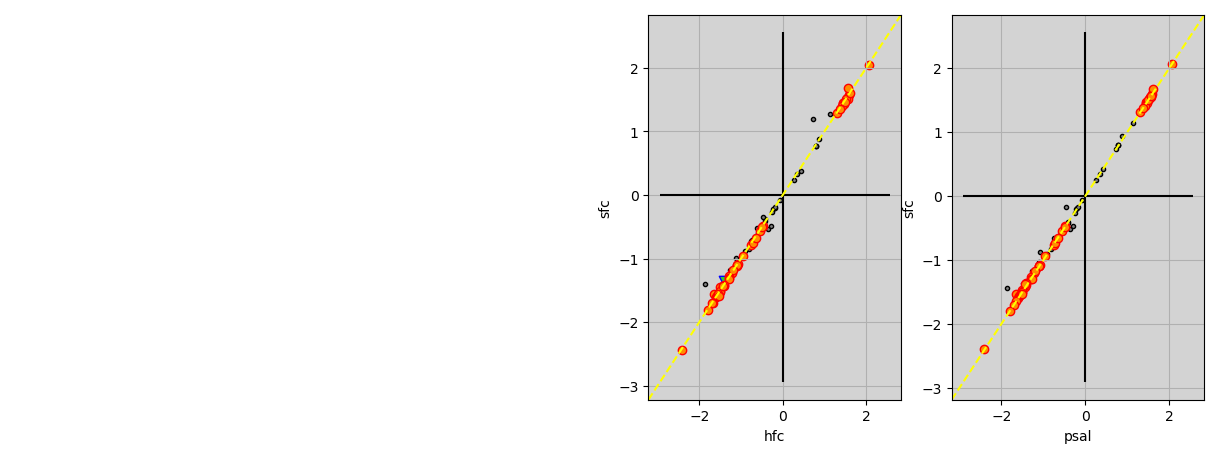

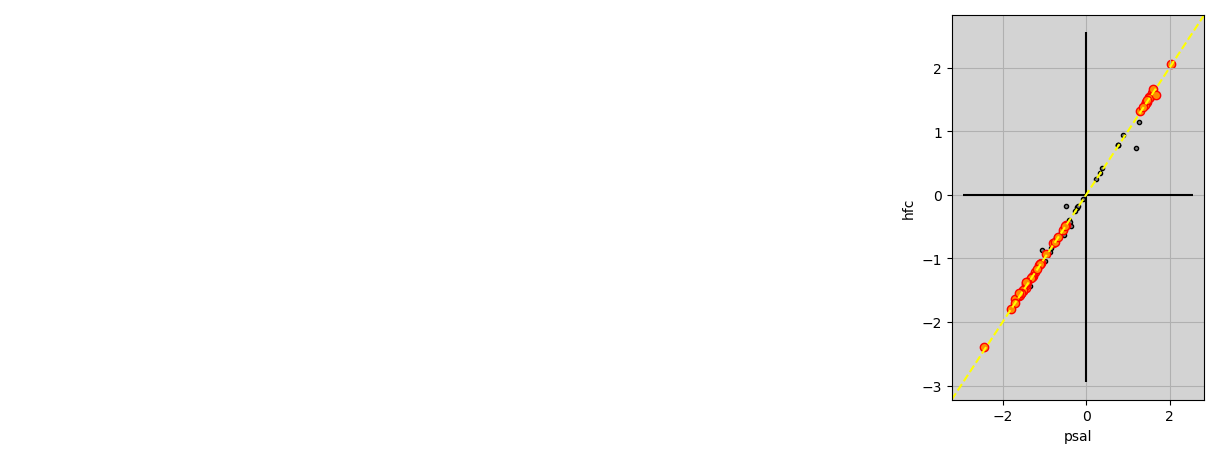

In [85]:
# DANIO RERIO: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(dr_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(dr_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(dr_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(dr_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(dr_ercc, 'hfc', 'psal', ax3, 'no')

### ERCC spike-in concentration log10 (y) vs. log10(TPM)
 as in Hoffmann et al. (2019)

#### ARABIDOPSIS: Prepare dataframes with ercc mix concentration and TPM data

In [86]:
# join featurecounts data (star + featurecounts)
sfc_flight1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/flight1.txt', sep='\t').rename(columns={'TPM':'flight1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_flight2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/flight2.txt', sep='\t').rename(columns={'TPM':'flight2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_flight3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/flight3.txt', sep='\t').rename(columns={'TPM':'flight3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/ground1.txt', sep='\t').rename(columns={'TPM':'ground1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/ground2.txt', sep='\t').rename(columns={'TPM':'ground2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm/ground3.txt', sep='\t').rename(columns={'TPM':'ground3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)

#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_flight1, sfc_flight2, sfc_flight3, sfc_ground1, sfc_ground2, sfc_ground3]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
at_sfc_tpm = pd.concat([d.set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [87]:
# join featurecounts data (hisat + featurecounts)
hfc_flight1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/flight1.txt', sep='\t').rename(columns={'TPM':'flight1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_flight2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/flight2.txt', sep='\t').rename(columns={'TPM':'flight2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_flight3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/flight3.txt', sep='\t').rename(columns={'TPM':'flight3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/ground1.txt', sep='\t').rename(columns={'TPM':'ground1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/ground2.txt', sep='\t').rename(columns={'TPM':'ground2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm/ground3.txt', sep='\t').rename(columns={'TPM':'ground3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)

#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_flight1, hfc_flight2, hfc_flight3, hfc_ground1, hfc_ground2, hfc_ground3]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
at_hfc_tpm = pd.concat([d.set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [88]:
at_sfc_tpm.to_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/sfc_tpm.tsv', sep='\t')

In [89]:
at_hfc_tpm.to_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/hfc_tpm.tsv', sep='\t')

In [90]:
at_ssal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/ssal_tpm.tsv', sep='\t')
at_psal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/psal_tpm.tsv', sep='\t')
at_srsem_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_tairdata/srsem_tpm.tsv', sep='\t')

In [91]:
ercc_conc = ercc_df[['gene_id', 'concentration in Mix 1 (attomoles/ul)',
       'concentration in Mix 2 (attomoles/ul)']]

In [92]:
# merge ercc concentration and tpm values from pipeline runs 
at_conc_tpm = ercc_conc.merge(at_ssal_tpm.merge(at_srsem_tpm.merge(at_sfc_tpm.merge(at_hfc_tpm.merge(at_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))

In [93]:
# append '_ssal' to star_salmon columns
at_conc_tpm = at_conc_tpm.rename(columns={'flight1':'flight1_ssal','flight2':'flight2_ssal', 'flight3':'flight3_ssal', 'ground1':'ground1_ssal', 'ground2':'ground2_ssal', 'ground3':'ground3_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)


In [94]:
# Apply log10 to all columns
at_log10 = at_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
at_log2 = at_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)

/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [95]:
flight_ssal = ['flight1_ssal', 'flight2_ssal','flight3_ssal'] 
ground_ssal = ['ground1_ssal', 'ground2_ssal', 'ground3_ssal']
#ssal_all = ['flight1_ssal', 'flight2_ssal','flight3_ssal', 'ground1_ssal', 'ground2_ssal', 'ground3_ssal']
flight_srsem = ['flight1_srsem', 'flight2_srsem', 'flight3_srsem']
ground_srsem = ['ground1_srsem', 'ground2_srsem', 'ground3_srsem']
flight_sfc = ['flight1_sfc','flight2_sfc', 'flight3_sfc']
ground_sfc = ['ground1_sfc', 'ground2_sfc','ground3_sfc']
flight_hfc = ['flight1_hfc', 'flight2_hfc', 'flight3_hfc']
ground_hfc = ['ground1_hfc', 'ground2_hfc', 'ground3_hfc']
flight_psal = ['flight1_psal','flight2_psal', 'flight3_psal'] 
ground_psal = ['ground1_psal', 'ground2_psal','ground3_psal']
lol = [flight_ssal, ground_ssal, flight_srsem, ground_srsem, flight_sfc, ground_sfc, flight_hfc, ground_hfc, flight_psal, ground_psal]


at_tpm_zero = at_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
at_tpm_zero = at_tpm_zero[at_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',at_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', at_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',at_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', at_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol:
    print(lst, at_conc_tpm[(at_conc_tpm[lst[0]]==0) & (at_conc_tpm[lst[1]]==0) & (at_conc_tpm[lst[2]]==0)].shape[0])
print('Undetected ercc spike-ins: ',at_tpm_zero['gene_id'].tolist())

range Mix1:  0.01430512 to 1.83105469
range Mix2:  0.00715256 to 0.45776367
['flight1_ssal', 'flight2_ssal', 'flight3_ssal'] 19
['ground1_ssal', 'ground2_ssal', 'ground3_ssal'] 19
['flight1_srsem', 'flight2_srsem', 'flight3_srsem'] 19
['ground1_srsem', 'ground2_srsem', 'ground3_srsem'] 19
['flight1_sfc', 'flight2_sfc', 'flight3_sfc'] 19
['ground1_sfc', 'ground2_sfc', 'ground3_sfc'] 19
['flight1_hfc', 'flight2_hfc', 'flight3_hfc'] 19
['ground1_hfc', 'ground2_hfc', 'ground3_hfc'] 19
['flight1_psal', 'flight2_psal', 'flight3_psal'] 19
['ground1_psal', 'ground2_psal', 'ground3_psal'] 19
Undetected ercc spike-ins:  ['ERCC-00134', 'ERCC-00156', 'ERCC-00083', 'ERCC-00142', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00024', 'ERCC-00016', 'ERCC-00098', 'ERCC-00057', 'ERCC-00041', 'ERCC-00048']


In [96]:
at_test = at_tpm_zero.set_index('gene_id').drop(['concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'], axis=1)#[(at_tpm_zero == 0)]
at_test = at_test[(at_test == 0)].dropna()
at_undetected = at_test.index.tolist()
at_undetected

['ERCC-00134',
 'ERCC-00156',
 'ERCC-00083',
 'ERCC-00142',
 'ERCC-00138',
 'ERCC-00117',
 'ERCC-00075',
 'ERCC-00024',
 'ERCC-00016',
 'ERCC-00098',
 'ERCC-00057',
 'ERCC-00041',
 'ERCC-00048']

#### Homo sapiens: Prepare dataframes with ercc mix concentration and TPM data

In [97]:
# join featurecounts data (star + featurecounts)
sfc_A1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/A1.txt', sep='\t').rename(columns={'TPM':'A1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/A2.txt', sep='\t').rename(columns={'TPM':'A2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/A3.txt', sep='\t').rename(columns={'TPM':'A3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A4 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/A4.txt', sep='\t').rename(columns={'TPM':'A4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A5 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/A5.txt', sep='\t').rename(columns={'TPM':'A5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/B1.txt', sep='\t').rename(columns={'TPM':'B1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/B2.txt', sep='\t').rename(columns={'TPM':'B2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/B3.txt', sep='\t').rename(columns={'TPM':'B3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B4 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/B4.txt', sep='\t').rename(columns={'TPM':'B4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B5 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/sfc_tpm/B5.txt', sep='\t').rename(columns={'TPM':'B5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_A1, sfc_A2, sfc_A3, sfc_A4, sfc_A5, sfc_B1, sfc_B2, sfc_B3, sfc_B4, sfc_B5]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
hs_sfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [98]:
# join featurecounts data (star + featurecounts)
hfc_A1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/A1.txt', sep='\t').rename(columns={'TPM':'A1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/A2.txt', sep='\t').rename(columns={'TPM':'A2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/A3.txt', sep='\t').rename(columns={'TPM':'A3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A4 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/A4.txt', sep='\t').rename(columns={'TPM':'A4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A5 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/A5.txt', sep='\t').rename(columns={'TPM':'A5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B1 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/B1.txt', sep='\t').rename(columns={'TPM':'B1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B2 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/B2.txt', sep='\t').rename(columns={'TPM':'B2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B3 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/B3.txt', sep='\t').rename(columns={'TPM':'B3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B4 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/B4.txt', sep='\t').rename(columns={'TPM':'B4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B5 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/hfc_tpm/B5.txt', sep='\t').rename(columns={'TPM':'B5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_A1, hfc_A2, hfc_A3, hfc_A4, hfc_A5, hfc_B1, hfc_B2, hfc_B3, hfc_B4, hfc_B5]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
hs_hfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [99]:
hs_ssal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/ssal_tpm.tsv', sep='\t')
hs_psal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/psal_tpm.tsv', sep='\t')
hs_srsem_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_hsdata/srsem_tpm.tsv', sep='\t')

In [100]:
# merge ercc concentration and tpm values from pipeline runs 
hs_conc_tpm = ercc_conc.merge(hs_ssal_tpm.merge(hs_srsem_tpm.merge(hs_sfc_tpm.merge(hs_hfc_tpm.merge(hs_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))
# append '_ssal' to star_salmon columns
hs_conc_tpm = hs_conc_tpm.rename(columns={'A1':'A1_ssal','A2':'A2_ssal', 'A3':'A3_ssal', 'A4':'A4_ssal', 'A5':'A5_ssal', 'B1':'B1_ssal', 'B2':'B2_ssal', 'B3':'B3_ssal', 'B4':'B4_ssal', 'B5':'B5_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)
# Apply log10 to all columns
hs_log10 = hs_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
hs_log2 = hs_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)


/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [101]:
#hs_conc_tpm.columns

In [102]:
A_ssal = ['A1_ssal', 'A2_ssal', 'A3_ssal', 'A4_ssal', 'A5_ssal'] 
B_ssal = ['B1_ssal', 'B2_ssal', 'B3_ssal', 'B4_ssal', 'B5_ssal']
A_srsem = ['A1_srsem', 'A2_srsem', 'A3_srsem', 'A4_srsem', 'A5_srsem']
B_srsem = ['B1_srsem', 'B2_srsem', 'B3_srsem', 'B4_srsem', 'B5_srsem' ]
A_sfc = ['A1_sfc','A2_sfc', 'A3_sfc', 'A4_sfc', 'A5_sfc']
B_sfc = ['B1_sfc', 'B2_sfc','B3_sfc', 'B4_sfc', 'B5_sfc']
A_hfc = ['A1_hfc', 'A2_hfc', 'A3_hfc', 'A4_hfc', 'A5_hfc']
B_hfc = ['B1_hfc', 'B2_hfc', 'B3_hfc', 'B4_hfc', 'B5_hfc']
A_psal = ['A1_psal','A2_psal', 'A3_psal', 'A4_psal', 'A5_psal'] 
B_psal = ['B1_psal', 'B2_psal','B3_psal', 'B4_psal', 'B5_psal']
lol_hs = [A_ssal, B_ssal, A_srsem, B_srsem, A_sfc, B_sfc, A_hfc, B_hfc, A_psal, B_psal]


hs_tpm_zero = hs_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
hs_tpm_zero = hs_tpm_zero[hs_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol_hs:
    sub_hs = hs_conc_tpm[(hs_conc_tpm[lst[0]]==0) & (hs_conc_tpm[lst[1]]==0) & (hs_conc_tpm[lst[2]]==0) & (hs_conc_tpm[lst[3]]==0)& (hs_conc_tpm[lst[4]]==0)]
    print(lst, hs_conc_tpm[(hs_conc_tpm[lst[0]]==0) & (hs_conc_tpm[lst[1]]==0) & (hs_conc_tpm[lst[2]]==0)& (hs_conc_tpm[lst[3]]==0)& (hs_conc_tpm[lst[4]]==0)].shape[0])
    print(sub_hs['gene_id'].to_list())
print('Undetected ercc spike-ins: ',hs_tpm_zero['gene_id'].tolist())

range Mix1:  nan to nan
range Mix2:  nan to nan
['A1_ssal', 'A2_ssal', 'A3_ssal', 'A4_ssal', 'A5_ssal'] 2
['ERCC-00057', 'ERCC-00048']
['B1_ssal', 'B2_ssal', 'B3_ssal', 'B4_ssal', 'B5_ssal'] 2
['ERCC-00017', 'ERCC-00083']
['A1_srsem', 'A2_srsem', 'A3_srsem', 'A4_srsem', 'A5_srsem'] 2
['ERCC-00057', 'ERCC-00048']
['B1_srsem', 'B2_srsem', 'B3_srsem', 'B4_srsem', 'B5_srsem'] 2
['ERCC-00017', 'ERCC-00083']
['A1_sfc', 'A2_sfc', 'A3_sfc', 'A4_sfc', 'A5_sfc'] 2
['ERCC-00057', 'ERCC-00048']
['B1_sfc', 'B2_sfc', 'B3_sfc', 'B4_sfc', 'B5_sfc'] 2
['ERCC-00017', 'ERCC-00083']
['A1_hfc', 'A2_hfc', 'A3_hfc', 'A4_hfc', 'A5_hfc'] 2
['ERCC-00057', 'ERCC-00048']
['B1_hfc', 'B2_hfc', 'B3_hfc', 'B4_hfc', 'B5_hfc'] 2
['ERCC-00017', 'ERCC-00083']
['A1_psal', 'A2_psal', 'A3_psal', 'A4_psal', 'A5_psal'] 2
['ERCC-00057', 'ERCC-00048']
['B1_psal', 'B2_psal', 'B3_psal', 'B4_psal', 'B5_psal'] 2
['ERCC-00017', 'ERCC-00083']
Undetected ercc spike-ins:  []


In [103]:
mix1_undetected = ['ERCC-00057', 'ERCC-00048']
mix2_undetected = ['ERCC-00017', 'ERCC-00083']
#print('range Mix1: ',hs_conc_tpm[hs_conc_tpm['gene_id']==(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
#print('range Mix2: ',hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
print(hs_conc_tpm[hs_conc_tpm['gene_id'].isin(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].tolist())
print(hs_conc_tpm[hs_conc_tpm['gene_id'].isin(mix2_undetected)]['concentration in Mix 2 (attomoles/ul)'].tolist())

[0.01430512, 0.01430512]
[0.02861023, 0.00715256]


#### Danio rerio: prepare dataframes

In [104]:
# join featurecounts data (star + featurecounts)
sfc_sham11 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_11.txt', sep='\t').rename(columns={'TPM':'sham11'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham12 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_12.txt', sep='\t').rename(columns={'TPM':'sham12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham21 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_21.txt', sep='\t').rename(columns={'TPM':'sham21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham22 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_22.txt', sep='\t').rename(columns={'TPM':'sham22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham31 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_31.txt', sep='\t').rename(columns={'TPM':'sham31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham32 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sham_32.txt', sep='\t').rename(columns={'TPM':'sham32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs11 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_11.txt', sep='\t').rename(columns={'TPM':'sbs11'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs12 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_12.txt', sep='\t').rename(columns={'TPM':'sbs12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs21 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_21.txt', sep='\t').rename(columns={'TPM':'sbs21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs22 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_22.txt', sep='\t').rename(columns={'TPM':'sbs22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs31 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_31.txt', sep='\t').rename(columns={'TPM':'sbs31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs32 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/sfc/sbs_32.txt', sep='\t').rename(columns={'TPM':'sbs32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_sham11, sfc_sham12, sfc_sham21, sfc_sham22, sfc_sham31, sfc_sham32, sfc_sbs11, sfc_sbs12, sfc_sbs21, sfc_sbs22, sfc_sbs31, sfc_sbs32]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
dr_sfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [105]:
# join featurecounts data (star + featurecounts)
hfc_sham11 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_11.txt', sep='\t').rename(columns={'TPM':'sham11'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham12 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_12.txt', sep='\t').rename(columns={'TPM':'sham12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham21 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_21.txt', sep='\t').rename(columns={'TPM':'sham21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham22 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_22.txt', sep='\t').rename(columns={'TPM':'sham22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham31 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_31.txt', sep='\t').rename(columns={'TPM':'sham31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham32 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sham_32.txt', sep='\t').rename(columns={'TPM':'sham32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs11 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_11.txt', sep='\t').rename(columns={'TPM':'sbs11'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs12 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_12.txt', sep='\t').rename(columns={'TPM':'sbs12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs21 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_21.txt', sep='\t').rename(columns={'TPM':'sbs21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs22 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_22.txt', sep='\t').rename(columns={'TPM':'sbs22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs31 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_31.txt', sep='\t').rename(columns={'TPM':'sbs31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs32 = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/hfc/sbs_32.txt', sep='\t').rename(columns={'TPM':'sbs32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_sham11, hfc_sham12, hfc_sham21, hfc_sham22, hfc_sham31, hfc_sham32, hfc_sbs11, hfc_sbs12, hfc_sbs21, hfc_sbs22, hfc_sbs31, hfc_sbs32]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
dr_hfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [106]:
dr_colnames = {'SRR3655791':'sham11', 'SRR3655792':'sham12', 'SRR3655793':'sham21',
       'SRR3655794':'sham22', 'SRR3655795':'sham31', 'SRR3655796':'sham32', 'SRR3655797':'sbs11', 'SRR3655798':'sbs12',
       'SRR3655799':'sbs21', 'SRR3655800':'sbs22', 'SRR3655801':'sbs31', 'SRR3655802':'sbs32'}
dr_ssal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/ssal_tpm.tsv', sep='\t').rename(columns=dr_colnames)
dr_psal_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/psal_tpm.tsv', sep='\t').rename(columns=dr_colnames)
dr_srsem_tpm = pd.read_csv('/Users/lp1/Documents/RNAseq/deseq_daniodata/srsem_tpm.tsv', sep='\t').rename(columns=dr_colnames)

In [107]:
# merge ercc concentration and tpm values from pipeline runs 
dr_conc_tpm = ercc_conc.merge(dr_ssal_tpm.merge(dr_srsem_tpm.merge(dr_sfc_tpm.merge(dr_hfc_tpm.merge(dr_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))
# append '_ssal' to star_salmon columns
dr_conc_tpm = dr_conc_tpm.rename(columns={'sham11':'sham11_ssal','sham12':'sham12_ssal', 'sham21':'sham21_ssal', 'sham22':'sham22_ssal', 'sham31':'sham31_ssal', 'sham32':'sham32_ssal','sbs11':'sbs11_ssal','sbs12':'sbs12_ssal', 'sbs21':'sbs21_ssal', 'sbs22':'sbs22_ssal', 'sbs31':'sbs31_ssal', 'sbs32':'sbs32_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)
# Apply log10 to all columns
dr_log10 = dr_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
dr_log2 = dr_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)


/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [108]:
#dr_conc_tpm.columns

In [109]:
sham_ssal = ['sham11_ssal', 'sham12_ssal', 'sham21_ssal', 'sham22_ssal', 'sham31_ssal', 'sham32_ssal'] 
sbs_ssal = ['sbs11_ssal', 'sbs12_ssal', 'sbs21_ssal', 'sbs22_ssal', 'sbs31_ssal','sbs32_ssal']
sham_srsem = ['sham11_srsem', 'sham12_srsem','sham21_srsem', 'sham22_srsem', 'sham31_srsem', 'sham32_srsem']
sbs_srsem = ['sbs11_srsem', 'sbs12_srsem', 'sbs21_srsem', 'sbs22_srsem', 'sbs31_srsem', 'sbs32_srsem']
sham_sfc = ['sham11_sfc', 'sham12_sfc', 'sham21_sfc', 'sham22_sfc', 'sham31_sfc', 'sham32_sfc']
sbs_sfc = ['sbs11_sfc', 'sbs12_sfc', 'sbs21_sfc', 'sbs22_sfc', 'sbs31_sfc', 'sbs32_sfc']
sham_hfc = ['sham11_hfc','sham12_hfc', 'sham21_hfc', 'sham22_hfc', 'sham31_hfc', 'sham32_hfc']
sbs_hfc = ['sbs11_hfc', 'sbs12_hfc', 'sbs21_hfc', 'sbs22_hfc', 'sbs31_hfc', 'sbs32_hfc']
sham_psal = ['sham11_psal', 'sham12_psal', 'sham21_psal', 'sham22_psal','sham31_psal', 'sham32_psal'] 
sbs_psal = ['sbs11_psal', 'sbs12_psal', 'sbs21_psal','sbs22_psal', 'sbs31_psal', 'sbs32_psal']
lol_dr = [sham_ssal, sbs_ssal, sham_srsem, sbs_srsem, sham_sfc, sbs_sfc, sham_hfc, sbs_hfc, sham_psal, sbs_psal]


dr_tpm_zero = dr_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
dr_tpm_zero = dr_tpm_zero[dr_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',dr_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', dr_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',dr_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', dr_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol_dr:
    sub_dr = dr_conc_tpm[(dr_conc_tpm[lst[0]]==0) & (dr_conc_tpm[lst[1]]==0) & (dr_conc_tpm[lst[2]]==0) & (dr_conc_tpm[lst[3]]==0) & (dr_conc_tpm[lst[4]]==0) & (dr_conc_tpm[lst[5]]==0)]
    print(lst, sub_dr.shape[0])
    print(sub_dr['gene_id'].to_list())
print('Undetected ercc spike-ins: ',dr_tpm_zero['gene_id'].tolist())

range Mix1:  0.01430512 to 0.02861023
range Mix2:  0.00715256 to 0.02861023
['sham11_ssal', 'sham12_ssal', 'sham21_ssal', 'sham22_ssal', 'sham31_ssal', 'sham32_ssal'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
['sbs11_ssal', 'sbs12_ssal', 'sbs21_ssal', 'sbs22_ssal', 'sbs31_ssal', 'sbs32_ssal'] 7
['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
['sham11_srsem', 'sham12_srsem', 'sham21_srsem', 'sham22_srsem', 'sham31_srsem', 'sham32_srsem'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
['sbs11_srsem', 'sbs12_srsem', 'sbs21_srsem', 'sbs22_srsem', 'sbs31_srsem', 'sbs32_srsem'] 7
['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
['sham11_sfc', 'sham12_sfc', 'sham21_sfc', 'sham22_sfc', 'sham31_sfc', 'sham32_sfc'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138'

In [110]:
mix1_undetected = ['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
mix2_undetected = ['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
#16,48,75,83,86,104,117,138
#17,48,57,75,83,98,156
#three in common. 48,75,83
print(dr_conc_tpm[dr_conc_tpm['gene_id'].isin(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].tolist())
print(dr_conc_tpm[dr_conc_tpm['gene_id'].isin(mix2_undetected)]['concentration in Mix 2 (attomoles/ul)'].tolist())

[0.02861023, 0.22888184, 0.11444092, 0.05722046, 0.01430512, 0.22888184, 0.11444092, 0.01430512]
[0.11444092, 0.02861023, 0.00715256, 0.01430512, 0.08583069, 0.02145767, 0.02861023]


#### Functions for drawing graph

In [111]:
# create a df for flattened data (concentration and tpm) for one pipeline run
def flatten6(df, col1, col2, pipe):
    df1 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'1_'+pipe]]
    df2 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'2_'+pipe]]
    df3 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'3_'+pipe]]
    df4 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'1_'+pipe]]
    df5 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'2_'+pipe]]
    df6 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'3_'+pipe]]
    df_out = pd.DataFrame(np.concatenate((df1.values, df2.values, df3.values, df4.values, df5.values, df6.values), axis=0))
    df_out.columns = ['gene_id','conc_mix', 'tpm_'+pipe]
    return df_out

In [112]:
def flatten12(df, col1, col2, pipe):
    df1 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'11_'+pipe]]
    df2 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'12_'+pipe]]
    df3 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'21_'+pipe]]
    df4 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'22_'+pipe]]
    df5 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'31_'+pipe]]
    df6 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'32_'+pipe]]
    df7 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'11_'+pipe]]
    df8 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'12_'+pipe]]
    df9 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'21_'+pipe]]
    df10 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'22_'+pipe]]
    df11 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'31_'+pipe]]
    df12 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'32_'+pipe]]
    df_out = pd.DataFrame(np.concatenate((df1.values, df2.values, df3.values, df4.values, df5.values, df6.values, df7.values, df8.values, df9.values, df10.values, df11.values, df12.values), axis=0))
    df_out.columns = ['gene_id','conc_mix', 'tpm_'+pipe]
    return df_out

In [113]:
#draw the scatter plot with log10 concentration and tpm values for one pipeline
def draw_conctpm(df, pipe):
    df = flatten(df, pipe)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(0)
    #df = df.fillna(0)
    col1 = 'tpm_'+pipe
    col2 = 'conc_mix'
#draw scatterplot
    fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=(10,10))
    ax.scatter(df[col1], df[col2], c='grey', edgecolors='grey', marker='.')
    ax.axline((1, 1), slope=1, c='yellow', ls='--', lw=3)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='grey', ls='--', lw=0.7)
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
# print regression params
    #print(f"y = {a:.2}*x + {b:.2}")
    print('y = {:.3}x + ({:.3})'.format(a,b))
    print(f'R Squared: {reg.score(x,y):.3}')
    #print('log2 feature counts shift: {:.3}'.format(-b/a))
    print('Reference R Squared: {:.3}'.format(r2))

In [114]:
def draw_ax(df, col1, col2, pipe, ax, flatten, logbase):
    if(flatten==6):
        df = flatten6(df, col1, col2, pipe)
    else:
        df = flatten12(df, col1, col2, pipe)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(0)
    #df = df.fillna(0)
    col1 = 'tpm_'+pipe
    col2 = 'conc_mix'
#draw scatterplot
    #fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=(10,10))
    ax.scatter(df[col1], df[col2], c='grey', edgecolors='grey', marker='.')
    ax.axline((1, 1), slope=1, c='grey', ls='--', lw=1)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_title(pipe)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='red', ls='--', lw=1)
    print(f'regression coefficient ({pipe}) ={a:.3}')
#r2 to regression line
    print(f'R Squared ({pipe}): {reg.score(x,y):.3}')
#LLD (lower limit of detection): at least 1TPM - log10 = 0
    print(f'LLD ({pipe}): log{logbase} {b:.2} or {logbase**b:.3}')
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    print(f'R^2({pipe}) = {r2:.2}')
# mean squared error to reference line
    msqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
    print(f'msqerror({pipe}) = {msqerr:.2}')

regression coefficient (ssal) =0.96
R Squared (ssal): 0.916
LLD (ssal): log10 0.61 or 4.11
R^2(ssal) = 0.71
msqerror(ssal) = 0.68
regression coefficient (srsem) =0.959
R Squared (srsem): 0.912
LLD (srsem): log10 0.64 or 4.41
R^2(srsem) = 0.68
msqerror(srsem) = 0.71
regression coefficient (sfc) =0.968
R Squared (sfc): 0.92
LLD (sfc): log10 0.69 or 4.87
R^2(sfc) = 0.65
msqerror(sfc) = 0.75
regression coefficient (hfc) =0.966
R Squared (hfc): 0.917
LLD (hfc): log10 0.66 or 4.56
R^2(hfc) = 0.67
msqerror(hfc) = 0.72
regression coefficient (psal) =0.958
R Squared (psal): 0.914
LLD (psal): log10 0.61 or 4.05
R^2(psal) = 0.71
msqerror(psal) = 0.67


Text(0.5, 0, 'Log10(Transcripts per Million)')

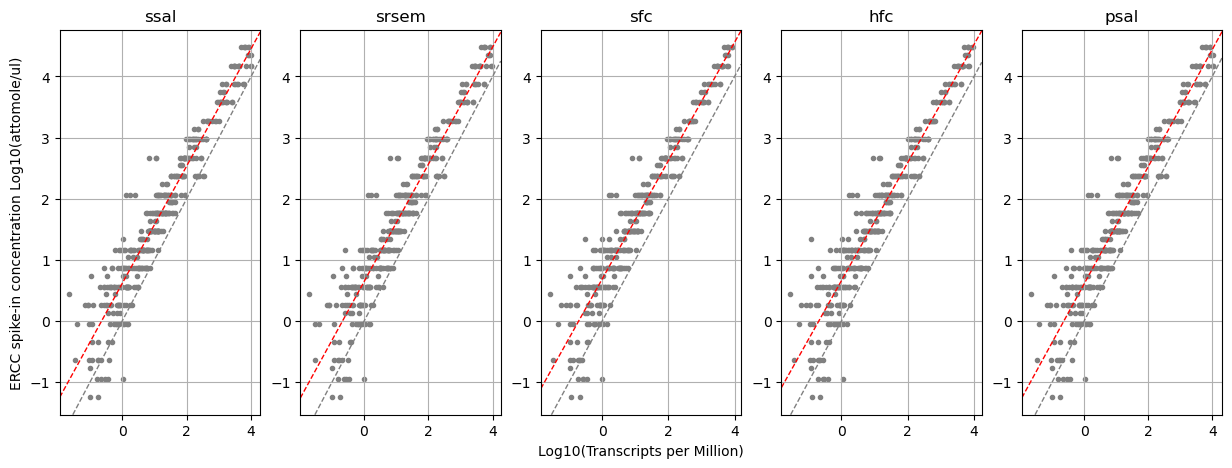

In [115]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(at_log10, 'flight', 'ground', 'ssal', ax0, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'srsem', ax1, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'sfc', ax2, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'hfc', ax3, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'psal', ax4, 6, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

regression coefficient (ssal) =0.96
R Squared (ssal): 0.916
LLD (ssal): log2 2.0 or 4.11
R^2(ssal) = 0.71
msqerror(ssal) = 2.3
regression coefficient (srsem) =0.959
R Squared (srsem): 0.912
LLD (srsem): log2 2.1 or 4.41
R^2(srsem) = 0.68
msqerror(srsem) = 2.4
regression coefficient (sfc) =0.968
R Squared (sfc): 0.92
LLD (sfc): log2 2.3 or 4.87
R^2(sfc) = 0.65
msqerror(sfc) = 2.5
regression coefficient (hfc) =0.966
R Squared (hfc): 0.917
LLD (hfc): log2 2.2 or 4.56
R^2(hfc) = 0.67
msqerror(hfc) = 2.4
regression coefficient (psal) =0.958
R Squared (psal): 0.914
LLD (psal): log2 2.0 or 4.05
R^2(psal) = 0.71
msqerror(psal) = 2.2


Text(0.5, 0, 'Log2(Transcripts per Million)')

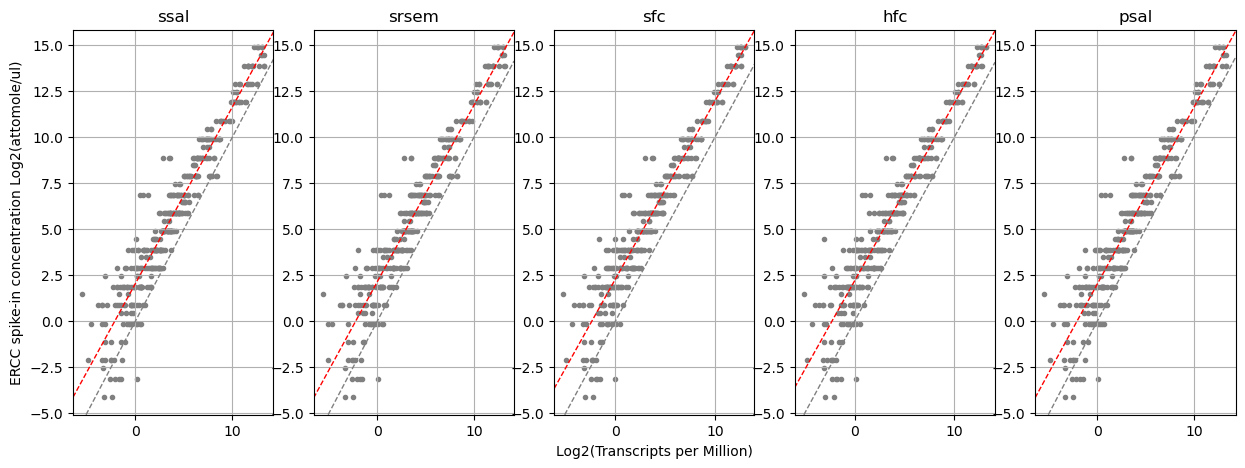

In [116]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(at_log2, 'flight', 'ground', 'ssal', ax0, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'srsem', ax1, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'sfc', ax2, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'hfc', ax3, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'psal', ax4, 6, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')

regression coefficient (ssal) =0.959
R Squared (ssal): 0.933
LLD (ssal): log10 0.58 or 3.81
R^2(ssal) = 0.78
msqerror(ssal) = 0.67
regression coefficient (srsem) =0.958
R Squared (srsem): 0.931
LLD (srsem): log10 0.59 or 3.88
R^2(srsem) = 0.78
msqerror(srsem) = 0.68
regression coefficient (sfc) =0.962
R Squared (sfc): 0.942
LLD (sfc): log10 1.3 or 18.5
R^2(sfc) = 0.17
msqerror(sfc) = 1.3
regression coefficient (hfc) =0.964
R Squared (hfc): 0.942
LLD (hfc): log10 1.2 or 17.6
R^2(hfc) = 0.19
msqerror(hfc) = 1.3
regression coefficient (psal) =0.955
R Squared (psal): 0.931
LLD (psal): log10 0.58 or 3.78
R^2(psal) = 0.79
msqerror(psal) = 0.67


Text(0.5, 0, 'Log10(Transcripts per Million)')

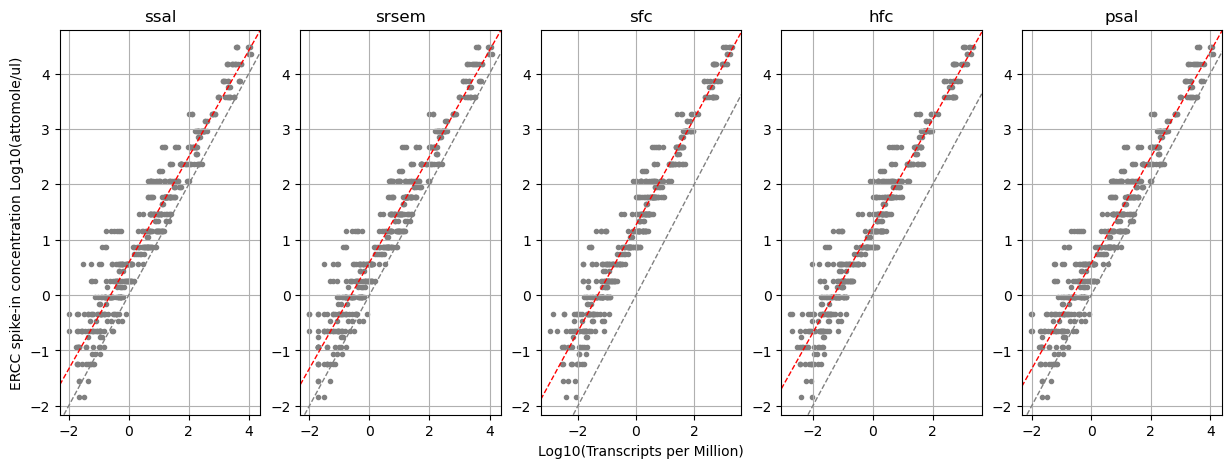

In [117]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(hs_log10, 'A', 'B', 'ssal', ax0, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'srsem', ax1, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'sfc', ax2, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'hfc', ax3, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'psal', ax4, 6, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

regression coefficient (ssal) =0.959
R Squared (ssal): 0.933
LLD (ssal): log2 1.9 or 3.81
R^2(ssal) = 0.78
msqerror(ssal) = 2.2
regression coefficient (srsem) =0.958
R Squared (srsem): 0.931
LLD (srsem): log2 2.0 or 3.88
R^2(srsem) = 0.78
msqerror(srsem) = 2.3
regression coefficient (sfc) =0.962
R Squared (sfc): 0.942
LLD (sfc): log2 4.2 or 18.5
R^2(sfc) = 0.17
msqerror(sfc) = 4.4
regression coefficient (hfc) =0.964
R Squared (hfc): 0.942
LLD (hfc): log2 4.1 or 17.6
R^2(hfc) = 0.19
msqerror(hfc) = 4.3
regression coefficient (psal) =0.955
R Squared (psal): 0.931
LLD (psal): log2 1.9 or 3.78
R^2(psal) = 0.79
msqerror(psal) = 2.2


Text(0.5, 0, 'Log2(Transcripts per Million)')

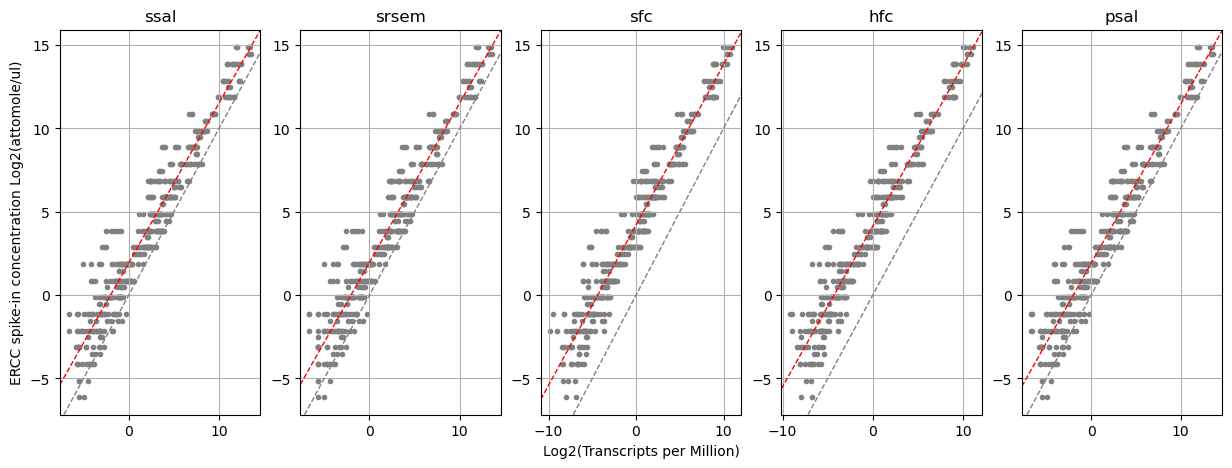

In [118]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(hs_log2, 'A', 'B', 'ssal', ax0, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'srsem', ax1, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'sfc', ax2, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'hfc', ax3, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'psal', ax4, 6, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')

regression coefficient (ssal) =0.93
R Squared (ssal): 0.865
LLD (ssal): log10 0.85 or 7.14
R^2(ssal) = 0.5
msqerror(ssal) = 0.95
regression coefficient (srsem) =0.949
R Squared (srsem): 0.891
LLD (srsem): log10 0.84 or 6.89
R^2(srsem) = 0.52
msqerror(srsem) = 0.92
regression coefficient (sfc) =0.95
R Squared (sfc): 0.893
LLD (sfc): log10 0.89 or 7.75
R^2(sfc) = 0.48
msqerror(sfc) = 0.96
regression coefficient (hfc) =0.951
R Squared (hfc): 0.894
LLD (hfc): log10 0.83 or 6.72
R^2(hfc) = 0.54
msqerror(hfc) = 0.9
regression coefficient (psal) =0.921
R Squared (psal): 0.855
LLD (psal): log10 0.83 or 6.81
R^2(psal) = 0.51
msqerror(psal) = 0.93


Text(0.5, 0, 'Log10(Transcripts per Million)')

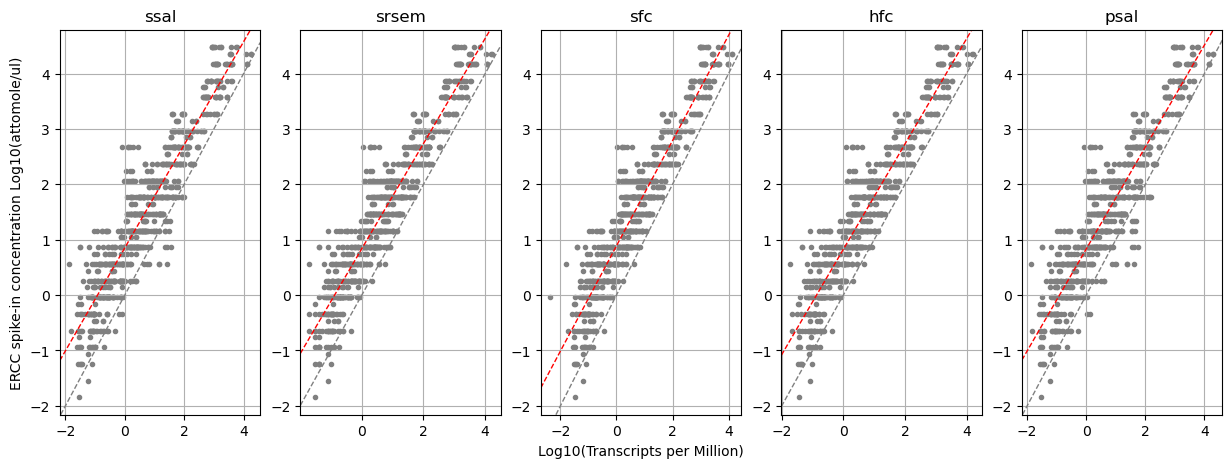

In [119]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(dr_log10, 'sham', 'sbs', 'ssal', ax0, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'srsem', ax1, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'sfc', ax2, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'hfc', ax3, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'psal', ax4, 12, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

regression coefficient (ssal) =0.93
R Squared (ssal): 0.865
LLD (ssal): log2 2.8 or 7.14
R^2(ssal) = 0.5
msqerror(ssal) = 3.1
regression coefficient (srsem) =0.949
R Squared (srsem): 0.891
LLD (srsem): log2 2.8 or 6.89
R^2(srsem) = 0.52
msqerror(srsem) = 3.0
regression coefficient (sfc) =0.95
R Squared (sfc): 0.893
LLD (sfc): log2 3.0 or 7.75
R^2(sfc) = 0.48
msqerror(sfc) = 3.2
regression coefficient (hfc) =0.951
R Squared (hfc): 0.894
LLD (hfc): log2 2.7 or 6.72
R^2(hfc) = 0.54
msqerror(hfc) = 3.0
regression coefficient (psal) =0.921
R Squared (psal): 0.855
LLD (psal): log2 2.8 or 6.81
R^2(psal) = 0.51
msqerror(psal) = 3.1


Text(0.5, 0, 'Log2(Transcripts per Million)')

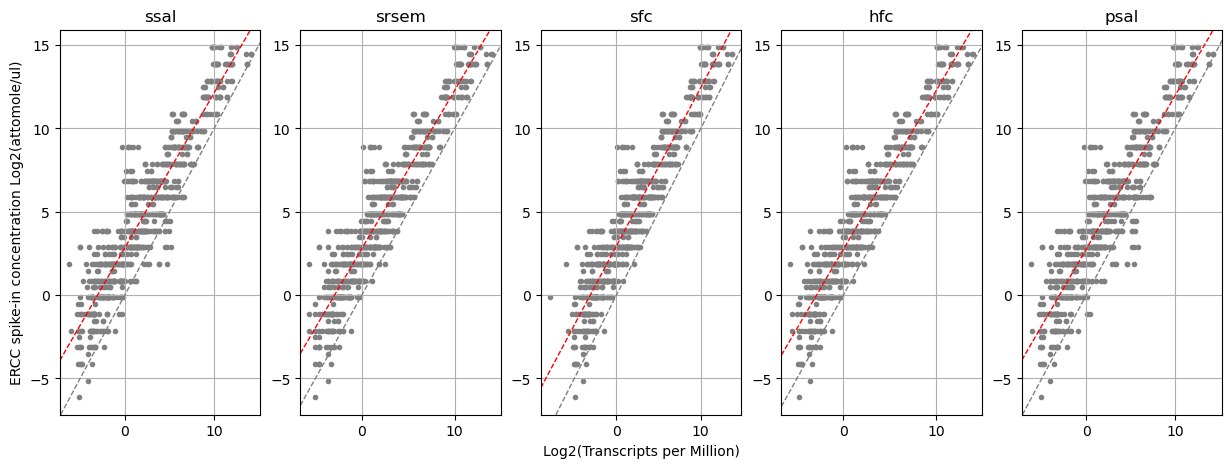

In [120]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(dr_log2, 'sham', 'sbs', 'ssal', ax0, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'srsem', ax1, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'sfc', ax2, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'hfc', ax3, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'psal', ax4, 12, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')